In [2]:
import pandas as pd
import numpy as np
import gzip
import os
import datetime
import pandas as pd
import calendar
import numpy as np
import glob
import sys
import gc
import re
#import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib
import pandas_ta as ta

import warnings

import requests

import hmac
import hashlib

import aiohttp
import asyncio

import logging
from datetime import timezone

import nest_asyncio

# Filter depreciation warnings from pandas regarding the append method
warnings.filterwarnings('ignore', category=FutureWarning, message=".*append.*")
pd.options.mode.chained_assignment = None

# Set pandas to display all digits for floating-point numbers
pd.options.display.float_format = '{:.8f}'.format

import os
from dotenv import load_dotenv

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Ignore only FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Ignore only RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

import importlib


from Orats_options_fetch_functions import *

from faster_numba_strategy_functions import *

import strategy_functions

importlib.reload(strategy_functions)
from strategy_functions import *

# import Common_functions

# importlib.reload(strategy_functions)
# importlib.reload(Common_functions)

# from Common_functions import *
# coin_desk_api_key =  "e43c1fd991e660b9bf959645f0800bb7e76fb4a3537ab773cec62b2fad31af2d"
from datetime import time
from pathlib import Path
# Get the user's home directory dynamically
home_dir = r"C:\Data\Options_logs"
#====================================

strategy_name = "Backtest_v1"

# Create a folder for the strategy_name if it doesn't exist in home directory

strategy_folder = os.path.join(home_dir, strategy_name)
if not os.path.exists(strategy_folder):
    os.makedirs(strategy_folder)

# Create the full path to the output file. this file contains all the trades

output_all_trades_file = os.path.join(strategy_folder, f"All_trades_{strategy_name}.csv")
trade_html_file = os.path.join(strategy_folder, f"Trade_stats_{strategy_name}.html")

#=== location to store the trade dataframe for debug

base_folder_df = "strategy_dataframe"
df_folder = os.path.join(strategy_folder, base_folder_df)
if not os.path.exists(df_folder):
    os.makedirs(df_folder)
    print("\n Created strategy dataframe folder : " ,df_folder )

#----- symbol_wise_trades

trades_folder = "sym_wise_trades"
trades_strategy_folder = os.path.join(strategy_folder, trades_folder)

if not os.path.exists(trades_strategy_folder):
    print("\n Making folder for symbol wise trades of strategy" , trades_strategy_folder)
    os.makedirs(trades_strategy_folder)

logger = setup_logger("Straddle_0DTE", strategy_folder, log_file="strategy.log" , to_console=False)


In [3]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to an in-memory database
con = duckdb.connect()

# --- Your setup code (which is correct) ---
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")
con.execute("""
SET s3_endpoint='122.176.133.73:9000';
SET s3_use_ssl=false;
SET s3_access_key_id='minioadmin';
SET s3_secret_access_key='minioadmin';
""")
con.execute("SET s3_url_style='path';") 
con.execute("PRAGMA threads=12;")
con.execute("PRAGMA enable_object_cache;")


# CORRECTED HTTPFS OPTIMIZATIONS
con.execute("""
SET http_keep_alive=true;
SET http_retries=5;
SET http_timeout=180;
""")


# --- THE MISSING STEP: Querying a file from S3 ---
# Replace with your actual S3 bucket and file path
# This can be a .parquet, .csv, or .json file
s3_file_path = 's3://duckdata/ORATS/Options/**/*.parquet'

try:
    # Execute a query on the S3 file and fetch the result as a Pandas DataFrame
    print(f"Querying data from: {s3_file_path}")
    df = con.execute(f"""
        SELECT *
        FROM '{s3_file_path}'
        LIMIT 2;
    """).df()

    print("\n✅ Query successful! First 5 rows of data:")
    print(df.head())

except Exception as e:
    print(f"\n❌ An error occurred during the query: {e}")

# finally:
#     # It's good practice to close the connection
#     con.close()

Querying data from: s3://duckdata/ORATS/Options/**/*.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


✅ Query successful! First 5 rows of data:
      expiry       strike  dte  optionType                  ts         low  \
0 2024-01-26 421.00000000   25          -1 2024-01-02 17:13:00 17.18000000   
1 2024-01-12 414.00000000   11          -1 2024-01-02 17:13:00 10.41500000   

         high        open       close     volume  ...      askSize  \
0 17.18000000 17.18000000 17.18000000 0.00000000  ...  50.00000000   
1 10.41500000 10.41500000 10.41500000 0.00000000  ... 151.00000000   

     bidPrice    askPrice      bidIv      askIv         iv          oi  \
0 17.12000000 17.24000000 0.13785700 0.14511500 0.14148600 15.00000000   
1 10.34000000 10.49000000 0.14267100 0.15199600 0.14733300 54.00000000   

    stockPrice        day ticker  
0 404.00000000 2024-01-02    QQQ  
1 404.00000000 2024-01-02    QQQ  

[2 rows x 21 columns]


In [4]:
# --- STRATEGY CONFIGURATION ---

# This defines the value of one strike step (e.g., for SPY, strikes are 1 point apart)
strike_interval = 1.0

# Example 1: 0DTE At-the-Money LONG STRADDLE
strategy_config = {
    'Leg1': {'action': 'SELL', 'option_type': 1, 'expiry_offset': 0, 'strike_offset': 1},  # Sell ATM Call
    }   # Buy 1DTE call

# 'Leg2': {'action': 'BUY', 'option_type': 1, 'expiry_offset': 1, 'strike_offset': 3

In [ ]:


ifol = r"C:\Data\Aggregate_Data\Options\USA\Raw_SPY_1min_2024_2025_ORATS_close.parquet"
#== read the RELIANCE data

com_df2 = pd.read_parquet(ifol)

if 'timestamp' in com_df2.columns:

    com_df2['timestamp'] = pd.to_datetime(com_df2['timestamp'])
    com_df2.set_index('timestamp' , inplace=True)
com_df2 = com_df2[~com_df2.index.duplicated(keep='first')]

com_df2.dropna(how='all', inplace=True)

vix_df = pd.read_parquet(r"C:\Data\Aggregate_Data\VIX_1_min_2019_2025.parquet")
com_df2 = com_df2.join(vix_df)


final_symbols = com_df2.filter(like='close').columns.str.replace('_close', '')
print("Total symbols found after all filtering: ", len(final_symbols))

# Calculate the number of rows in the DataFrame

com_df2[[f"{symbol}_intraday_low" for symbol in final_symbols]] =com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: intraday_low(com_df2, low_col=x.name,agg_func='min'))

com_df2[[f"{symbol}_intraday_high" for symbol in final_symbols]] =com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: intraday_high(com_df2, high_col=x.name,agg_func='max'))

com_df2[[f"{symbol}_todayo" for symbol in final_symbols]] = com_df2[[f'{symbol}_close' for symbol in final_symbols]].resample('D').transform('first')

# com_df2[[f"{symbol}_daily_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=50)

# com_df2[[f"{symbol}_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change()

# com_df2[[f"{symbol}_ROC_4" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=4)

com_df2[[f"{symbol}_prevdayl" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_prevdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_secdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=2, column=x.name))


# This single call does it for the 20-day MA
ma_20d_df = calculate_daily_ma_vectorized(df=com_df2, symbols=final_symbols, periods=3 , agg_func='last' , col_suffix='close')

    # Join the new features back to the main DataFrame
com_df2 = pd.concat([com_df2, ma_20d_df] , axis=1 , join='outer')


com_df2[[f"{symbol}_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(2).mean()

com_df2[[f"{symbol}_ROC_30" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].pct_change(periods=30)


#com_df2[[f"{symbol}_ma_3d_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].values / com_df2[[f"{symbol}_3d_MA" for symbol in final_symbols]].values

com_df2[[f"{symbol}_prevdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=1))

com_df2[[f"{symbol}_secdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=2))


# #=== hourly volume
# com_df2[[f"{symbol}_vol_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].rolling(4).mean()

# #==avg 3 day volume

# com_df2[[f"{symbol}_3d_vol_MA" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].apply(lambda x: daily_moving_average(com_df2, timeframe='1D', column=x.name, periods=3, agg_func='last'))

com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(5).mean()


com_df2[[f"{symbol}_3dlow" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=3, column=x.name))

com_df2[[f"{symbol}_3dhigh" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=3, column=x.name))



# 1. Get the lists of column names
high_3d_cols = [f"{symbol}_3dhigh" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_3dlow" for symbol in final_symbols]

# 2. Perform the calculation on NumPy arrays
range_values = (com_df2[high_3d_cols].values / com_df2[low_3d_cols].values) - 1

# 3. Create a new DataFrame from the results
# This is the key step to avoid the error.
range_cols = [f"{symbol}_3d_rng" for symbol in final_symbols]
range_df = pd.DataFrame(range_values, index=com_df2.index, columns=range_cols)

# 4. Join the new DataFrame back to the main one
com_df2 = com_df2.join(range_df)



# # Calculate highest high of last 4 bars
# com_df2[[f"{symbol}_high_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(10).max()

# # Calculate lowest low of last 4 bars
# com_df2[[f"{symbol}_low_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(10).min()

# # 1. Get the lists of column names
# high_cols = [f"{symbol}_high_4bar" for symbol in final_symbols]
# low_cols = [f"{symbol}_low_4bar" for symbol in final_symbols]

# # 2. Perform the calculation on the NumPy arrays
# range_values = com_df2[high_cols].values - com_df2[low_cols].values

# # 3. Create a new DataFrame from the result (This is the key step)
# range_cols = [f"{symbol}_range_4bar" for symbol in final_symbols]
# range_df = pd.DataFrame(range_values, index=com_df2.index, columns=range_cols)

# # 4. Join the new DataFrame back to the main one
# com_df2 = com_df2.join(range_df)


# # Calculate mean range (average of the 4-bar ranges)
# com_df2[[f"{symbol}_mean_range_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_range_4bar" for symbol in final_symbols]].rolling(12).mean()


# gc.collect()

# for symbol in final_symbols:

   
#     com_df2[f'{symbol}_iATR2'] = com_df2[f"{symbol}_ATR"].values / com_df2[f"{symbol}_close"].values


# 1. Define the column groups
close_cols = [f"{symbol}_close" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_3dlow" for symbol in final_symbols]
high_3d_cols = [f"{symbol}_3dhigh" for symbol in final_symbols]

# 2. Perform the calculation in a more chained and memory-conscious way
# Using .to_numpy(dtype=np.float32) can cut memory usage by 50%
numerator = com_df2[close_cols].to_numpy(dtype=np.float32) - com_df2[low_3d_cols].to_numpy(dtype=np.float32)
denominator = com_df2[high_3d_cols].to_numpy(dtype=np.float32) - com_df2[low_3d_cols].to_numpy(dtype=np.float32)

# np.divide handles division by zero safely
percentile_values = np.divide(numerator, denominator, where=denominator != 0)

# 3. Create the new feature DataFrame
pctl_cols = [f"{symbol}_3d_Pctl" for symbol in final_symbols]
percentile_df = pd.DataFrame(percentile_values, index=com_df2.index, columns=pctl_cols)

# 4. Clip values and join back (same as your code)
percentile_df = percentile_df.clip(0, 1)
com_df2 = com_df2.join(percentile_df)

com_df2['decent'] = np.where((com_df2['SPY_todayo'] < com_df2['SPY_prevdayc'] * 1.015) , 1, 0)
com_df = com_df2[com_df2['decent']==1]
com_df = com_df[com_df.index.year>=2024]
#com_df = com_df[com_df.index.year<2024]


Total symbols found after all filtering:  2
Calculating 3-day MA for 2 symbols...


In [6]:
import pandas as pd
import pandas_market_calendars as mcal

def fetch_option_data_for_n_days(con, ticker, end_date_str, n_days, strike, expiry_str, option_type):
    """
    Fetches a range of minute-level data for a single option contract
    for a specified number of business days ending on a given date.

    Args:
        con: The DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        end_date_str (str): The last day to query, in 'YYYY-MM-DD' format.
        n_days (int): The number of business days of data to fetch.
        strike (float): The specific strike price.
        expiry_str (str): The expiry date to filter for, in 'YYYY-MM-DD' format.
        option_type (int): The type of option to fetch (1 for Calls, 0 for Puts).

    Returns:
        pd.DataFrame: A DataFrame containing the minute-by-minute data.
    """
    option_name = "Call" if option_type == 1 else "Put"
    #print(f"Fetching last {n_days} b-days of data ending on {end_date_str} for {ticker} {strike} {option_name} expiring {expiry_str}...")
    
    try:
        # --- Business Day Calculation Logic ---
        # 1. Get the market calendar
        nyse = mcal.get_calendar('NYSE')
        
        # 2. To be safe, find a start date far enough in the past
        #    (n * 2 is a safe buffer for weekends/holidays)
        start_buffer = pd.to_datetime(end_date_str) - pd.Timedelta(days=n_days * 2)
        
        # 3. Generate a schedule of valid trading days
        schedule = nyse.schedule(start_date=start_buffer, end_date=end_date_str)
        
        # 4. Get the last 'n_days' from the schedule and format them
        business_day_list = [d.strftime('%Y-%m-%d') for d in schedule.index[-n_days:]]
        
        # --- Query Logic (remains the same) ---
        path_list = [
            f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'"
            for d in business_day_list
        ]
        
        query = f"""
            SELECT ts, strike, expiry, dte, optionType, volume, oi, close,
                bidPrice, askPrice, iv, stockPrice, ticker
            FROM read_parquet([{",".join(path_list)}])
            WHERE 
                CAST(strike AS FLOAT) = {strike} AND
                expiry = '{expiry_str}' AND
                optionType = {option_type}
            ORDER BY ts;
        """
        
        multi_day_df = con.execute(query).df()
        
        if multi_day_df.empty:
            print("INFO: No data found for this contract in the specified date range.")
        
        multi_day_df['ts'] = pd.to_datetime(multi_day_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        multi_day_df.set_index('ts' , inplace=True)
        return multi_day_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

# ==============================================================================
# --- Example Usage ---
# ==============================================================================
# Assume 'con' is your active DuckDB connection

# Get data for the 5 business days ending on September 12, 2025
multi_day_df = fetch_option_data_for_n_days(
    con=con,
    ticker='SPY',
    end_date_str='2024-04-12', # The last day of the range
    n_days=1,                  # How many business days to go back
    strike=510.0,
    expiry_str='2024-04-12',
    option_type=1              # 1 for Call
)

if not multi_day_df.empty:
    print("\n--- Found Data for Date Range ---")
    print(multi_day_df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Found Data for Date Range ---
                          strike     expiry  dte  optionType         volume  \
ts                                                                            
2024-04-12 09:30:00 510.00000000 2024-04-12    1           1 -1514.00000000   
2024-04-12 09:31:00 510.00000000 2024-04-12    1           1    30.00000000   
2024-04-12 09:32:00 510.00000000 2024-04-12    1           1     6.00000000   
2024-04-12 09:33:00 510.00000000 2024-04-12    1           1    34.00000000   
2024-04-12 09:34:00 510.00000000 2024-04-12    1           1    72.00000000   
...                          ...        ...  ...         ...            ...   
2024-04-12 15:56:00 510.00000000 2024-04-12    1           1  1958.00000000   
2024-04-12 15:57:00 510.00000000 2024-04-12    1           1   695.00000000   
2024-04-12 15:58:00 510.00000000 2024-04-12    1           1   604.00000000   
2024-04-12 15:59:00 510.00000000 2024-04-12    1           1   609.00000000   
2024-04-12 16:00:

In [6]:

def fetch_bulk_option_data_call_put(con, ticker, end_date_str, n_days, strikes: List[float], expiries: List[str] , option_type: int = 0 ):
    
    """
    Fetches a range of minute-level data for MULTIPLE option contracts
    in a single, efficient query.

    Args:
        con: The database connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        end_date_str (str): The end date for the data fetch in 'YYYY-MM-DD' format.
        n_days (int): The number of business days to look back.
        strikes (List[float]): A list of strike prices to fetch.
        expiries (List[str]): A list of expiry dates in 'YYYY-MM-DD' format.
        option_type (int, optional): The type of option to fetch. 
                                     1 for Calls, -1 for Puts, 0 for Both. 
                                     Defaults to 0.
    
    Returns:
        pd.DataFrame: A DataFrame containing the requested option data, or an empty
                      DataFrame if no data is found or an error occurs.
    """

    # 1. Get the list of business days to query (same as before)
    nyse = mcal.get_calendar('NYSE')
    start_buffer = pd.to_datetime(end_date_str) - pd.Timedelta(days=n_days)
    schedule = nyse.schedule(start_date=start_buffer, end_date=end_date_str)
    business_day_list = [d.strftime('%Y-%m-%d') for d in schedule.index[-n_days:]]
    
    # 1. Validate the option_type parameter first
    if option_type not in [1, -1, 0]:
        print(f"❌ Bad input for option_type: '{option_type}'. Must be 1 (Call), -1 (Put), or 0 (Both).")
        return pd.DataFrame()


    # 2. Build the list of S3 paths (same as before)
    path_list = [
        f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'"
        for d in business_day_list ]
    
    # ▼▼▼ NEW QUERY LOGIC ▼▼▼
    # 3. Format the lists for the SQL 'IN' clause
    strikes_str = ",".join(map(str, strikes)) # For numbers: 470.0,471.0,472.0
    expiries_str = ",".join([f"'{e}'" for e in expiries]) # For strings: '2024-01-05','2024-01-08'
    
    # ▼▼▼ NEW LOGIC: DYNAMIC QUERY FILTER ▼▼▼
    # 2. Build the optionType filter string based on the parameter
    option_type_filter_str = ""
    if option_type == 1:
        option_type_filter_str = "AND optionType = 1"
    elif option_type == -1:
        option_type_filter_str = "AND optionType = -1"



    query = f"""
        SELECT ts, strike, expiry, close, bidPrice, askPrice, oi, dte, optionType , iv
        FROM read_parquet([{",".join(path_list)}])
        WHERE 
            CAST(strike AS FLOAT) IN ({strikes_str}) AND
            expiry IN ({expiries_str})
            {option_type_filter_str} 
        ORDER BY ts;
    """
    
    try:
        bulk_df = con.execute(query).df()
        
        if bulk_df.empty:
            return pd.DataFrame()
            
        # Perform timezone conversion and set index (same as before)
        bulk_df['ts'] = pd.to_datetime(bulk_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        bulk_df.set_index('ts' , inplace=True)
        return bulk_df
        
    except Exception as e:
        print(f"An error occurred during bulk fetch: {e}")
        return pd.DataFrame()

In [ ]:

com_legs_df[[f"{legs}_intraday_low" for legs in legs_to_process]] =com_legs_df[[f"{legs}_bidPrice" for legs in legs_to_process]].apply(lambda x: intraday_low(com_legs_df, low_col=x.name,agg_func='min'))

com_legs_df[[f"{legs}_intraday_high" for legs in legs_to_process]] =com_legs_df[[f"{legs}_askPrice" for legs in legs_to_process]].apply(lambda x: intraday_high(com_legs_df, high_col=x.name,agg_func='max'))

# Calculate Today's Opening Price for each leg
com_legs_df[[f'{leg}_todayo' for leg in legs_to_process]] =  com_legs_df[[f'{leg}_close' for leg in legs_to_process]].resample('D').transform('first')

# Calculate Previous Day's Low (using bidPrice) for each leg
com_legs_df[[f"{leg}_prevdayl" for leg in legs_to_process]] = com_legs_df[[f"{leg}_bidPrice" for leg in legs_to_process]].apply(lambda x: get_x_day_low_numba(com_legs_df, n=1, column=x.name))

# Calculate Previous Day's High (using askPrice) for each leg
com_legs_df[[f"{leg}_prevdayh" for leg in legs_to_process]] = \
    com_legs_df[[f"{leg}_askPrice" for leg in legs_to_process]].apply(lambda x: get_x_day_high_numba(com_legs_df, n=1, column=x.name) )

close_cols = [f'{leg}_close' for leg in legs_to_process]
window_size = 15

# 1. Rolling 15-Bar Highest Close
com_legs_df[[f'{leg}_15min_high' for leg in legs_to_process]] = \
    com_legs_df[close_cols].rolling(window=window_size).max()

# 2. Rolling 15-Bar Lowest Close
com_legs_df[[f'{leg}_15min_low' for leg in legs_to_process]] = \
    com_legs_df[close_cols].rolling(window=window_size).min()

# 3. Rolling 15-Bar Mean Close
com_legs_df[[f'{leg}_15min_mean' for leg in legs_to_process]] = \
    com_legs_df[close_cols].rolling(window=window_size).mean()

com_legs_df[[f'{leg}_ROC_5' for leg in legs_to_process]] = com_legs_df[[f"{leg}_close" for leg in legs_to_process]].pct_change(periods=5)



In [7]:
def log_and_close_trade(leg_name, exit_timestamp, exit_price, exit_reason, state_dicts, final_trade_log_list, option_multiplier=1):
    """
    Logs the details of a closed trade, calculates profit, and resets all state variables for that leg.
    """
    # Unpack the state dictionaries for easier access
    is_in_position, position_side, entry_price, qty, entry_timestamp, bar_count = \
        state_dicts['is_in_position'], state_dicts['position_side'], state_dicts['entry_price'], \
        state_dicts['qty'], state_dicts['entry_timestamp'], state_dicts['bar_count']

    # Check if the position actually exists before trying to close it
    if leg_name not in entry_price:
        print(f"⚠️  Warning: Trying to close non-existent position {leg_name}. Skipping.")
        return
    
    # Get the details of the position being closed
    side = position_side.get(leg_name)
    
    # Additional safety checks
    if side is None:
        print(f"⚠️  Warning: No position side found for {leg_name}. Skipping.")
        return
        
    if leg_name not in qty:
        print(f"⚠️  Warning: No quantity found for {leg_name}. Skipping.")
        return

    # Calculate profit
    profit = (exit_price - entry_price[leg_name]) * qty[leg_name] * side * option_multiplier

    # Create the trade log entry
    trade_details = {
        'name': leg_name,
        'Side': 'BUY' if side == 1 else 'SELL',
        'entry_date': entry_timestamp.get(leg_name, exit_timestamp),  # Use exit timestamp as fallback
        'entry_price': entry_price[leg_name],
        'qty': qty[leg_name],
        'exit_date': exit_timestamp,
        'exit_price': exit_price,
        'profit': profit,
        'bars_held': bar_count.get(leg_name, 0),
        'exit_reason': exit_reason
    }
    final_trade_log_list.append(trade_details)
    
    print(f"  -> {exit_reason} EXIT for {leg_name}. Profit: ${profit:.2f} and exit price is {exit_price:.2f}")

    # Reset all state variables for this leg (with safety checks)
    for dict_name, state_dict in state_dicts.items():
        if leg_name in state_dict:
            del state_dict[leg_name]
            #print(f"    Cleared {leg_name} from {dict_name}")

In [ ]:
# ==============================================================================
# SCRIPT STARTS HERE
# ==============================================================================

import pandas_market_calendars as mcal
lookback_days = 1
nyse = mcal.get_calendar('NYSE')

# Initialize a list to hold all trade dictionaries.
final_trade_log_list = []
option_multiplier = 1

# --- Main Loop: Iterate Through Each Day ---
unique_days = com_df.index.normalize().unique()
print(f"🚀 Starting backtest for {len(unique_days)} unique days...")
for day in unique_days[1:]:
    day_str = day.strftime('%Y-%m-%d')
    print(f"\n--- Processing Day: {day_str} ---")

    try:
        # --- PHASE 1: PRE-FETCH DATA ---
        daily_underlying_df = com_df[com_df.index.date == day.date()]
        if daily_underlying_df.empty: 
            continue
            
        open_price = daily_underlying_df['SPY_close'].iloc[0]
        print(f"Fetching options across {open_price}")
                
        if pd.isna(open_price): 
            continue
        
        atm_strike_open = np.round(open_price)

        # ==============================================================================
        # --- PHASE 1: PRE-FETCH ALL POTENTIAL OPTION DATA FOR THE DAY ---
        # ==============================================================================
        
        strikes_to_fetch = set()
        expiries_to_fetch = set()
        legs_to_trade_info = {} # Store info to map data back to legs

        for leg_name, params in strategy_config.items():
            center_target_strike = atm_strike_open 
            # 1. Calculate the lower and upper price bounds
            lower_bound = center_target_strike * 0.995
            upper_bound = center_target_strike * 1.015

            # 2. Round the bounds to the nearest valid strike
            rounded_lower = round_to_nearest(lower_bound, interval=strike_interval)
            rounded_upper = round_to_nearest(upper_bound, interval=strike_interval)

            # 3. Generate all strikes from the lower to upper bound, inclusive
            all_strikes_in_range = np.arange(rounded_lower, rounded_upper + strike_interval, strike_interval)
                    
            # 4. Add all of these strikes to your set for fetching
            strikes_to_fetch.update(all_strikes_in_range)

            # The schedule is fetched once
            schedule = nyse.schedule(start_date=day, end_date=day + pd.Timedelta(days=14))

            # 1. Get the primary expiry offset from your config
            primary_offset = params['expiry_offset']

            # 2. Get and add the primary target expiry date
            target_expiry_str = schedule.index[primary_offset].strftime('%Y-%m-%d')
            expiries_to_fetch.add(target_expiry_str)

            # 3. Calculate the offset for the next trading day
            next_day_offset = primary_offset + 1
            

            # 4. Safely get and add the next day's expiry date
            if next_day_offset < len(schedule.index):
                next_day_expiry_str = schedule.index[next_day_offset].strftime('%Y-%m-%d')
                expiries_to_fetch.add(next_day_expiry_str)
            else:
                print(f"  -> Added expiry: {target_expiry_str} (No further date in schedule)")
            
            print(f"Both expiries are {target_expiry_str} and {next_day_expiry_str}")

            # Store the central parameters for this leg
            legs_to_trade_info[leg_name] = {'strike': center_target_strike, 'expiry': target_expiry_str}

        # Make one single, efficient call to fetch all data
        bulk_data_df = fetch_bulk_option_data_call_put(
            con=con, ticker='SPY', end_date_str=day_str, n_days=lookback_days,
            strikes=list(strikes_to_fetch), expiries=list(expiries_to_fetch), option_type=1)

        if bulk_data_df.empty:
            print("Could not pre-fetch any option data for the day. Skipping.")
            continue

        grps = bulk_data_df.groupby(by=['strike', 'optionType', 'expiry'])
        total_legs = grps.ngroups 

        print("\n--- Phase 2: Preparing Master DataFrame ---")

        # 1. Create a list to hold the processed DataFrame for each option contract
        all_option_dfs = []

        # 2. Loop through each group (each unique option contract)
        for (strike, option_type, expiry), contract_df in grps:
            
            # 3. Create a unique, descriptive prefix for this specific contract
            type_char = 'C' if option_type == 1 else 'P'
            expiry_str = pd.to_datetime(expiry).strftime('%Y%m%d')
            prefix = f"{type_char}_{strike}_{expiry_str}_"
            
            # 4. Add the prefix to all columns of this contract's DataFrame
            prefixed_df = contract_df.add_prefix(prefix)
            
            # 5. Add the prepared DataFrame to our list
            all_option_dfs.append(prefixed_df)

        # 6. Concatenate all individual option DataFrames into one wide DataFrame
        if all_option_dfs:
            com_legs_df = pd.concat(all_option_dfs, axis=1, join='outer')
            print(f"✅ Successfully created master DataFrame with {len(com_legs_df.columns)} total columns.")
        else:
            print("❌ No valid option groups to process.")
            continue

        legs_to_process = [symbol for symbol in com_legs_df.filter(like='_close').columns.str.replace('_close', '').unique()
                          if symbol.startswith('C_') or symbol.startswith('P_')]

        #print(legs_to_process)

        # Apply rolling calculations
        com_legs_df[[f"{legs}_intraday_low" for legs in legs_to_process]] = com_legs_df[[f"{legs}_bidPrice" for legs in legs_to_process]].apply(lambda x: intraday_low(com_legs_df, low_col=x.name, agg_func='min'))

        com_legs_df[[f"{legs}_intraday_high" for legs in legs_to_process]] = com_legs_df[[f"{legs}_askPrice" for legs in legs_to_process]].apply(lambda x: intraday_high(com_legs_df, high_col=x.name, agg_func='max'))

        close_cols = [f'{leg}_close' for leg in legs_to_process]
        com_legs_df[[f'{leg}_ma10' for leg in legs_to_process]] = com_legs_df[close_cols].rolling(window=10).mean()

        # Calculate Today's Opening Price for each leg
        com_legs_df[[f'{leg}_todayo' for leg in legs_to_process]] = com_legs_df[[f'{leg}_close' for leg in legs_to_process]].resample('D').transform('first')

        com_legs_df[[f'{leg}_ROC_5' for leg in legs_to_process]] = com_legs_df[[f"{leg}_close" for leg in legs_to_process]].pct_change(periods=10)
        
        # 7. Join the wide option data with the underlying SPY data
        com_df3 = pd.concat([daily_underlying_df, com_legs_df], join='outer', axis=1)
                
        # 1. Calculate the rounded ATM strike for every row
        atm_strikes = round_to_nearest(com_df3['SPY_close'], interval=1)
        atm1_strikes = round_to_nearest(com_df3['SPY_close'], interval=1) + 1

        # 2. Build the corresponding leg name for every row
        com_df3['current_atm_leg'] = 'C_' + atm_strikes.astype(str) + '_' + day.strftime('%Y%m%d')        

        # --- STATE DICTIONARIES (Reset for each day) ---
        is_in_position = {}
        position_side = {}
        entry_price = {}
        entry_spy_price = {} 
        qty = {}
        entry_timestamp = {}
        has_been_hedged = {}
        hedge_for_leg = {}
        bar_count = {}
        net_premiums = {}

        # --- MINUTE-BY-MINUTE BACKTESTING LOOP ---
        for i in range(len(com_df3)):
            
            timestamp = com_df3.index[i]
            row = com_df3.iloc[i]

                    # Package all state dictionaries to pass to the helper function
            state_dictionaries = {
                'is_in_position': is_in_position, 'position_side': position_side, 'entry_price': entry_price,
                'qty': qty, 'entry_timestamp': entry_timestamp, 'bar_count': bar_count, 
                'entry_spy_price': entry_spy_price, 'has_been_hedged': has_been_hedged         }


            # Update bar counts for existing positions
            for leg_name in list(is_in_position.keys()):
                bar_count[leg_name] = bar_count.get(leg_name, 0) + 1

            # --- Part A: Check for NEW Short Entry ---
            is_short_open = -1 in position_side.values()
            
            # Entry Condition: SPY is $1 below its open price today
            # and row['VIX_close']<row['VIX_todayo']*0.99
            short_entry_condition = (row['SPY_close'] < (com_df3['SPY_intraday_high'].iloc[i-1] - 1)  and row['SPY_ROC_30']<0.001 and timestamp.time() > time(9, 41) and (row['SPY_todayo'] < (com_df3['SPY_prevdayh'].iloc[i-1]*1.003)) and timestamp.time() < time(13, 35))

            if not is_short_open and short_entry_condition:
                atm_strike = round_to_nearest(row['SPY_close'], 1)
                target_strike = atm_strike + 2
                expiry_0dte = timestamp.strftime('%Y%m%d')
                leg_name = f"C_{target_strike}_{expiry_0dte}"
                
                if f"{leg_name}_askPrice" in row and row[f"{leg_name}_askPrice"] > 0.5  and row[f"{leg_name}_askPrice"]<com_df3[f"{leg_name}_intraday_high"].iloc[i-1]*0.9:
                    is_in_position[leg_name] = True
                    position_side[leg_name] = -1  # Sell
                    entry_price[leg_name] = row[f"{leg_name}_bidPrice"]
                    qty[leg_name] = 100
                    entry_spy_price[leg_name] = row['SPY_close']
                    entry_timestamp[leg_name] = timestamp
                    has_been_hedged[leg_name] = False
                    bar_count[leg_name] = 0

                    print(f"  -> SHORT ENTRY for {leg_name} at {timestamp.time()} at {row[f'{leg_name}_askPrice']}")
                    
            # --- Part B: Check for Hedge Entry ---
            primary_short_leg = next((leg for leg, side in position_side.items() if side == -1 and not has_been_hedged.get(leg, False)), None)
            short_strike = float(primary_short_leg.split('_')[1]) if primary_short_leg else None
            if primary_short_leg:
                
                spy_at_entry = entry_spy_price[primary_short_leg]
                current_spy = row['SPY_close']
                            # Skip if current SPY is NaN
                if pd.isna(current_spy):
                    continue
                hedge_qty = 0
                hedge_ratio = 0 
                
                if current_spy >= spy_at_entry + 0.5:

                    hedge_ratio = 0.95
                elif current_spy < spy_at_entry - 0.75:
                    hedge_ratio = 0.75    
                
                #print(f"  [HEDGE CHECK] {primary_short_leg}: Entry SPY={spy_at_entry:.2f}, Current={current_spy:.2f}")

                if hedge_ratio > 0:
                    #hedge_strike = round_to_nearest(current_spy, 1) + 2
                    hedge_strike = short_strike + 2
                    expiry_1dte = next_day_expiry_str.replace('-', '')
                    hedge_leg = f"C_{hedge_strike}_{expiry_1dte}"

                    if f"{hedge_leg}_askPrice" in row and row[f"{hedge_leg}_askPrice"] > 0:
                        
                        # Get the current prices and original quantity
                        short_price = row[f"{primary_short_leg}_askPrice"] # Current cost to close the short
                        hedge_price = row[f"{hedge_leg}_askPrice"]
                        short_qty = qty[primary_short_leg]
                        
                        # ▼▼▼ THIS IS THE DYNAMIC CALCULATION ▼▼▼
                        # Calculate the ideal quantity based on notional value
                        dynamic_qty = (hedge_ratio * short_price * short_qty) / hedge_price
                        
                        # Round to the nearest whole number for the final quantity
                        hedge_qty = max(30 , int(round(dynamic_qty, 0)))
                       

                        print(f"  -> HEDGE ENTRY of qty {hedge_qty} for {hedge_leg} against {primary_short_leg} and primary qty of {short_qty} at price {row[f'{hedge_leg}_askPrice']}")
                        is_in_position[hedge_leg] = True
                        position_side[hedge_leg] = 1  # Buy
                        entry_price[hedge_leg] = row[f"{hedge_leg}_askPrice"]
                        qty[hedge_leg] = int(hedge_qty)
                        entry_timestamp[hedge_leg] = timestamp
                        bar_count[hedge_leg] = 0
                        
                        has_been_hedged[primary_short_leg] = True
                        hedge_for_leg[primary_short_leg] = hedge_leg

                        # Track net premium
                        short_premium = entry_price[primary_short_leg] * qty[primary_short_leg]
                        long_premium = entry_price[hedge_leg] * qty[hedge_leg]
                        net_credit = short_premium - long_premium
                        net_premiums[primary_short_leg] = net_credit
                        print(f"  -> COMBINED: Net credit = ${net_credit:.2f}")

            # --- Part C: Check Stop-Loss for Combined Positions ---
            for primary_leg in list(net_premiums.keys()):
                if primary_leg not in is_in_position:
                    continue
                if primary_leg not in hedge_for_leg:
                    continue
                    
                hedge_leg = hedge_for_leg[primary_leg]
                short_current = row.get(f"{primary_leg}_askPrice", 0)
                long_current = row.get(f"{hedge_leg}_bidPrice", 0)
                
                if short_current > 0 and long_current > 0:
                    short_entry_price = entry_price[primary_leg]
                    long_entry_price = entry_price[hedge_leg]

                    # Get quantities
                    short_qty = qty[primary_leg]
                    long_qty = qty[hedge_leg]

                    # 1. Calculate P&L for the SHORT leg
                    pnl_short = (short_entry_price - short_current) * short_qty

                    # 2. Calculate P&L for the LONG leg
                    pnl_long = (long_current - long_entry_price) * long_qty

                    # 3. Calculate the total combined P&L
                    pnl_change = pnl_short + pnl_long
                                        
                    
                    
                    if pnl_change <= -30 or pnl_short <= -25:
                        
                        print(f"  🚨 STOP-LOSS TRIGGERED for {primary_leg}+{hedge_leg}")
                        print(f"     Entry short was : ${short_entry_price:.2f}, Current short leg price: ${short_current:.2f}")
                        print(f"     Entry long was : ${long_entry_price:.2f}, Current short leg price: ${long_current:.2f}")
                        
                        print(f"   Total  Loss: ${pnl_change:.2f}")

                                            # Call the helper function for the SHORT leg
                        log_and_close_trade(
                            leg_name=primary_leg, 
                            exit_timestamp=timestamp, 
                            exit_price=short_current, # Use the askPrice to buy-to-close
                            exit_reason='SPREAD_STOP_LOSS', 
                            state_dicts=state_dictionaries, 
                            final_trade_log_list=final_trade_log_list
                        )
                        
                        # Call the helper function for the LONG leg
                        log_and_close_trade(
                            leg_name=hedge_leg, 
                            exit_timestamp=timestamp, 
                            exit_price=long_current, # Use the bidPrice to sell-to-close
                            exit_reason='SPREAD_STOP_LOSS', 
                            state_dicts=state_dictionaries, 
                            final_trade_log_list=final_trade_log_list
                        )
                        
                        # Clean up the spread-specific dictionaries
                        del hedge_for_leg[primary_leg]
                        del net_premiums[primary_leg]



            # --- Part D: Manage EOD Exits ---
            if timestamp.time() >= time(15, 45) and is_in_position:
                print(f"  [EOD] Checking positions to close at {timestamp.time()}")
                print(f"  [EOD] Current positions: {list(is_in_position.keys())}")
                for leg_name in list(is_in_position.keys()):
                    side = position_side[leg_name]

                                # Get appropriate exit price with multiple fallbacks
                    if side == -1:  # Short - buy to close at ask price
                        exit_price = (row.get(f"{leg_name}_askPrice") or 
                                    row.get(f"{leg_name}_close") or 
                                    0.01)  # Final fallback
                    else:  # Long (hedge) - sell to close at bid price
                        exit_price = (row.get(f"{leg_name}_bidPrice") or 
                                    row.get(f"{leg_name}_close") or 
                                    0.01)  # Final fallback
                                
                    print(f"  [EOD] Processing {leg_name}: side={side}, price={exit_price}")
                    if pd.notna(exit_price) and exit_price > 0:
                        # ▼▼▼ REPLACED with function call ▼▼▼
                        log_and_close_trade(leg_name, timestamp, exit_price, 'EOD', state_dictionaries, final_trade_log_list, option_multiplier)
                        
                        # Clean up any remaining spread-specific state if this was a primary leg
                        if leg_name in hedge_for_leg: del hedge_for_leg[leg_name]
                        if leg_name in net_premiums: del net_premiums[leg_name]
                            # Clear all tracking dictionaries
                is_in_position.clear()
                position_side.clear()
                entry_price.clear()
                qty.clear()
                entry_timestamp.clear()
                bar_count.clear()
                entry_spy_price.clear()
                has_been_hedged.clear()
                hedge_for_leg.clear()
                net_premiums.clear()      
                        
    except Exception as e:
        print(f"  ❌ An error occurred on {day_str}: {e}")
        import traceback
        traceback.print_exc()

# --- Convert final log to DataFrame ---
if final_trade_log_list:
    local_trade_log2 = pd.DataFrame(final_trade_log_list)
    print(f"Trading completed. Total trades: {len(local_trade_log2)}")
else:
    print("No trades were made.")

🚀 Starting backtest for 239 unique days...

--- Processing Day: 2024-01-04 ---
Fetching options across 468.44
Both expiries are 2024-01-04 and 2024-01-05


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-05 ---
Fetching options across 468.15
Both expiries are 2024-01-05 and 2024-01-08


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-08 ---
Fetching options across 468.64
Both expiries are 2024-01-08 and 2024-01-09


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-09 ---
Fetching options across 472.0
Both expiries are 2024-01-09 and 2024-01-10


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-10 ---
Fetching options across 474.35
Both expiries are 2024-01-10 and 2024-01-11


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-11 ---
Fetching options across 477.93
Both expiries are 2024-01-11 and 2024-01-12


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.
  -> SHORT ENTRY for C_478.0_20240111 at 10:00:00 at 0.51
  -> HEDGE ENTRY of qty 82 for C_480.0_20240112 against C_478.0_20240111 and primary qty of 100 at price 0.3
  -> COMBINED: Net credit = $25.40
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_478.0_20240111', 'C_480.0_20240112']
  [EOD] Processing C_478.0_20240111: side=-1, price=0.01
  -> EOD EXIT for C_478.0_20240111. Profit: $49.00 and exit price is 0.01
  [EOD] Processing C_480.0_20240112: side=1, price=0.13
  -> EOD EXIT for C_480.0_20240112. Profit: $-13.94 and exit price is 0.13

--- Processing Day: 2024-01-12 ---
Fetching options across 477.91
Both expiries are 2024-01-12 and 2024-01-16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-16 ---
Fetching options across 475.37
Both expiries are 2024-01-16 and 2024-01-17


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-17 ---
Fetching options across 471.78
Both expiries are 2024-01-17 and 2024-01-18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-18 ---
Fetching options across 474.0
Both expiries are 2024-01-18 and 2024-01-19


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-19 ---
Fetching options across 477.44
Both expiries are 2024-01-19 and 2024-01-22


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-22 ---
Fetching options across 484.13
Both expiries are 2024-01-22 and 2024-01-23


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-23 ---
Fetching options across 484.23
Both expiries are 2024-01-23 and 2024-01-24


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-24 ---
Fetching options across 487.47
Both expiries are 2024-01-24 and 2024-01-25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-25 ---
Fetching options across 487.11
Both expiries are 2024-01-25 and 2024-01-26


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-26 ---
Fetching options across 487.8
Both expiries are 2024-01-26 and 2024-01-29


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-29 ---
Fetching options across 487.7
Both expiries are 2024-01-29 and 2024-01-30


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-30 ---
Fetching options across 490.89
Both expiries are 2024-01-30 and 2024-01-31


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-01-31 ---
Fetching options across 488.7
Both expiries are 2024-01-31 and 2024-02-01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.
  -> SHORT ENTRY for C_490.0_20240131 at 09:47:00 at 0.7
  -> HEDGE ENTRY of qty 55 for C_492.0_20240201 against C_490.0_20240131 and primary qty of 100 at price 0.72
  -> COMBINED: Net credit = $29.40
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_490.0_20240131', 'C_492.0_20240201']
  [EOD] Processing C_490.0_20240131: side=-1, price=0.01
  -> EOD EXIT for C_490.0_20240131. Profit: $68.00 and exit price is 0.01
  [EOD] Processing C_492.0_20240201: side=1, price=0.06
  -> EOD EXIT for C_492.0_20240201. Profit: $-36.30 and exit price is 0.06

--- Processing Day: 2024-02-01 ---
Fetching options across 485.15
Both expiries are 2024-02-01 and 2024-02-02


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.
  -> SHORT ENTRY for C_486.0_20240201 at 10:02:00 at 0.69
  -> HEDGE ENTRY of qty 87 for C_488.0_20240202 against C_486.0_20240201 and primary qty of 100 at price 1.01
  -> COMBINED: Net credit = $-19.87
  🚨 STOP-LOSS TRIGGERED for C_486.0_20240201+C_488.0_20240202
     Entry short was : $0.68, Current short leg price: $0.95
     Entry long was : $1.01, Current short leg price: $1.02
   Total  Loss: $-26.13
  -> SPREAD_STOP_LOSS EXIT for C_486.0_20240201. Profit: $-27.00 and exit price is 0.95
  -> SPREAD_STOP_LOSS EXIT for C_488.0_20240202. Profit: $0.87 and exit price is 1.02
  -> SHORT ENTRY for C_486.0_20240201 at 10:56:00 at 0.62
  -> HEDGE ENTRY of qty 79 for C_488.0_20240202 against C_486.0_20240201 and primary qty of 100 at price 0.87
  -> COMBINED: Net credit = $-7.73
  🚨 STOP-LOSS TRIGGERED for C_486.0_20240201+C_488.0_20240202
     Entry short was : $0.61, Current sho

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-02-05 ---
Fetching options across 493.25
Both expiries are 2024-02-05 and 2024-02-06


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-02-06 ---
Fetching options across 493.98
Both expiries are 2024-02-06 and 2024-02-07


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 171 total columns.

--- Processing Day: 2024-02-07 ---
Fetching options across 496.32
Both expiries are 2024-02-07 and 2024-02-08


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-08 ---
Fetching options across 497.78
Both expiries are 2024-02-08 and 2024-02-09


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 162 total columns.

--- Processing Day: 2024-02-09 ---
Fetching options across 499.13
Both expiries are 2024-02-09 and 2024-02-12


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-02-12 ---
Fetching options across 501.24
Both expiries are 2024-02-12 and 2024-02-13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-02-13 ---
Fetching options across 494.3
Both expiries are 2024-02-13 and 2024-02-14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.
  -> SHORT ENTRY for C_496.0_20240213 at 09:50:00 at 0.53
  -> HEDGE ENTRY of qty 73 for C_498.0_20240214 against C_496.0_20240213 and primary qty of 100 at price 0.31
  -> COMBINED: Net credit = $29.37
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_496.0_20240213', 'C_498.0_20240214']
  [EOD] Processing C_496.0_20240213: side=-1, price=0.01
  -> EOD EXIT for C_496.0_20240213. Profit: $51.00 and exit price is 0.01
  [EOD] Processing C_498.0_20240214: side=1, price=0.13
  -> EOD EXIT for C_498.0_20240214. Profit: $-13.14 and exit price is 0.13

--- Processing Day: 2024-02-14 ---
Fetching options across 497.01
Both expiries are 2024-02-14 and 2024-02-15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-02-15 ---
Fetching options across 499.49
Both expiries are 2024-02-15 and 2024-02-16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-02-16 ---
Fetching options across 501.71
Both expiries are 2024-02-16 and 2024-02-20


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_502.0_20240216 at 09:53:00 at 0.54
  -> HEDGE ENTRY of qty 70 for C_504.0_20240220 against C_502.0_20240216 and primary qty of 100 at price 0.47
  -> COMBINED: Net credit = $20.10
  🚨 STOP-LOSS TRIGGERED for C_502.0_20240216+C_504.0_20240220
     Entry short was : $0.53, Current short leg price: $0.82
     Entry long was : $0.47, Current short leg price: $0.76
   Total  Loss: $-8.70
  -> SPREAD_STOP_LOSS EXIT for C_502.0_20240216. Profit: $-29.00 and exit price is 0.82
  -> SPREAD_STOP_LOSS EXIT for C_504.0_20240220. Profit: $20.30 and exit price is 0.76

--- Processing Day: 2024-02-20 ---
Fetching options across 497.88
Both expiries are 2024-02-20 and 2024-02-21


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-02-21 ---
Fetching options across 495.45
Both expiries are 2024-02-21 and 2024-02-22


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.
  -> SHORT ENTRY for C_497.0_20240221 at 12:07:00 at 0.61
  -> HEDGE ENTRY of qty 66 for C_499.0_20240222 against C_497.0_20240221 and primary qty of 100 at price 1.06
  -> COMBINED: Net credit = $-9.96
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_497.0_20240221', 'C_499.0_20240222']
  [EOD] Processing C_497.0_20240221: side=-1, price=0.74
  -> EOD EXIT for C_497.0_20240221. Profit: $-14.00 and exit price is 0.74
  [EOD] Processing C_499.0_20240222: side=1, price=1.14
  -> EOD EXIT for C_499.0_20240222. Profit: $5.28 and exit price is 1.14

--- Processing Day: 2024-02-22 ---
Fetching options across 503.44
Both expiries are 2024-02-22 and 2024-02-23


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-02-23 ---
Fetching options across 509.27
Both expiries are 2024-02-23 and 2024-02-26


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 162 total columns.

--- Processing Day: 2024-02-26 ---
Fetching options across 508.37
Both expiries are 2024-02-26 and 2024-02-27


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 144 total columns.

--- Processing Day: 2024-02-27 ---
Fetching options across 506.53
Both expiries are 2024-02-27 and 2024-02-28


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-02-28 ---
Fetching options across 505.53
Both expiries are 2024-02-28 and 2024-02-29


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-02-29 ---
Fetching options across 508.17
Both expiries are 2024-02-29 and 2024-03-01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-01 ---
Fetching options across 509.44
Both expiries are 2024-03-01 and 2024-03-04


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-04 ---
Fetching options across 512.16
Both expiries are 2024-03-04 and 2024-03-05


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-05 ---
Fetching options across 510.15
Both expiries are 2024-03-05 and 2024-03-06


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-06 ---
Fetching options across 510.43
Both expiries are 2024-03-06 and 2024-03-07


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_511.0_20240306 at 10:04:00 at 0.61
  -> HEDGE ENTRY of qty 63 for C_513.0_20240307 against C_511.0_20240306 and primary qty of 100 at price 0.48
  -> COMBINED: Net credit = $29.76
  🚨 STOP-LOSS TRIGGERED for C_511.0_20240306+C_513.0_20240307
     Entry short was : $0.60, Current short leg price: $0.86
     Entry long was : $0.48, Current short leg price: $0.86
   Total  Loss: $-2.06
  -> SPREAD_STOP_LOSS EXIT for C_511.0_20240306. Profit: $-26.00 and exit price is 0.86
  -> SPREAD_STOP_LOSS EXIT for C_513.0_20240307. Profit: $23.94 and exit price is 0.86

--- Processing Day: 2024-03-07 ---
Fetching options across 513.39
Both expiries are 2024-03-07 and 2024-03-08


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-08 ---
Fetching options across 515.42
Both expiries are 2024-03-08 and 2024-03-11


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-11 ---
Fetching options across 510.3
Both expiries are 2024-03-11 and 2024-03-12


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_511.0_20240311 at 10:02:00 at 0.54
  -> HEDGE ENTRY of qty 30 for C_513.0_20240312 against C_511.0_20240311 and primary qty of 100 at price 0.99
  -> COMBINED: Net credit = $23.30
  🚨 STOP-LOSS TRIGGERED for C_511.0_20240311+C_513.0_20240312
     Entry short was : $0.53, Current short leg price: $0.82
     Entry long was : $0.99, Current short leg price: $1.46
   Total  Loss: $-14.90
  -> SPREAD_STOP_LOSS EXIT for C_511.0_20240311. Profit: $-29.00 and exit price is 0.82
  -> SPREAD_STOP_LOSS EXIT for C_513.0_20240312. Profit: $14.10 and exit price is 1.46

--- Processing Day: 2024-03-12 ---
Fetching options across 513.57
Both expiries are 2024-03-12 and 2024-03-13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-13 ---
Fetching options across 517.03
Both expiries are 2024-03-13 and 2024-03-14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-14 ---
Fetching options across 516.71
Both expiries are 2024-03-14 and 2024-03-15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_517.0_20240314 at 09:49:00 at 0.55
  -> HEDGE ENTRY of qty 115 for C_519.0_20240315 against C_517.0_20240314 and primary qty of 100 at price 0.3
  -> COMBINED: Net credit = $19.50
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_517.0_20240314', 'C_519.0_20240315']
  [EOD] Processing C_517.0_20240314: side=-1, price=0.01
  -> EOD EXIT for C_517.0_20240314. Profit: $53.00 and exit price is 0.01
  [EOD] Processing C_519.0_20240315: side=1, price=0.06
  -> EOD EXIT for C_519.0_20240315. Profit: $-27.60 and exit price is 0.06

--- Processing Day: 2024-03-15 ---
Fetching options across 510.77
Both expiries are 2024-03-15 and 2024-03-18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_512.0_20240315 at 09:45:00 at 0.64
  -> HEDGE ENTRY of qty 55 for C_514.0_20240318 against C_512.0_20240315 and primary qty of 100 at price 0.69
  -> COMBINED: Net credit = $24.05
  🚨 STOP-LOSS TRIGGERED for C_512.0_20240315+C_514.0_20240318
     Entry short was : $0.62, Current short leg price: $0.89
     Entry long was : $0.69, Current short leg price: $0.95
   Total  Loss: $-12.70
  -> SPREAD_STOP_LOSS EXIT for C_512.0_20240315. Profit: $-27.00 and exit price is 0.89
  -> SPREAD_STOP_LOSS EXIT for C_514.0_20240318. Profit: $14.30 and exit price is 0.95

--- Processing Day: 2024-03-18 ---
Fetching options across 514.14
Both expiries are 2024-03-18 and 2024-03-19


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-19 ---
Fetching options across 511.8
Both expiries are 2024-03-19 and 2024-03-20


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-20 ---
Fetching options across 515.47
Both expiries are 2024-03-20 and 2024-03-21


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-21 ---
Fetching options across 523.12
Both expiries are 2024-03-21 and 2024-03-22


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-22 ---
Fetching options across 522.11
Both expiries are 2024-03-22 and 2024-03-25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-25 ---
Fetching options across 519.95
Both expiries are 2024-03-25 and 2024-03-26


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-26 ---
Fetching options across 520.99
Both expiries are 2024-03-26 and 2024-03-27


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-27 ---
Fetching options across 521.52
Both expiries are 2024-03-27 and 2024-03-28


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-03-28 ---
Fetching options across 523.04
Both expiries are 2024-03-28 and 2024-04-01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 207 total columns.

--- Processing Day: 2024-04-01 ---
Fetching options across 523.63
Both expiries are 2024-04-01 and 2024-04-02


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.

--- Processing Day: 2024-04-02 ---
Fetching options across 518.42
Both expiries are 2024-04-02 and 2024-04-03


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-04-03 ---
Fetching options across 518.4
Both expiries are 2024-04-03 and 2024-04-04


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-04-04 ---
Fetching options across 523.39
Both expiries are 2024-04-04 and 2024-04-05


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-04-05 ---
Fetching options across 514.25
Both expiries are 2024-04-05 and 2024-04-08


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_517.0_20240405 at 10:27:00 at 0.68
  -> HEDGE ENTRY of qty 74 for C_519.0_20240408 against C_517.0_20240405 and primary qty of 100 at price 1.12
  -> COMBINED: Net credit = $-15.88
  🚨 STOP-LOSS TRIGGERED for C_517.0_20240405+C_519.0_20240408
     Entry short was : $0.67, Current short leg price: $0.92
     Entry long was : $1.12, Current short leg price: $1.14
   Total  Loss: $-23.52
  -> SPREAD_STOP_LOSS EXIT for C_517.0_20240405. Profit: $-25.00 and exit price is 0.92
  -> SPREAD_STOP_LOSS EXIT for C_519.0_20240408. Profit: $1.48 and exit price is 1.14

--- Processing Day: 2024-04-08 ---
Fetching options across 519.08
Both expiries are 2024-04-08 and 2024-04-09


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-04-09 ---
Fetching options across 520.49
Both expiries are 2024-04-09 and 2024-04-10


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_518.0_20240409 at 10:37:00 at 0.54
  -> HEDGE ENTRY of qty 31 for C_520.0_20240410 against C_518.0_20240409 and primary qty of 100 at price 0.97
  -> COMBINED: Net credit = $22.93
  🚨 STOP-LOSS TRIGGERED for C_518.0_20240409+C_520.0_20240410
     Entry short was : $0.53, Current short leg price: $0.78
     Entry long was : $0.97, Current short leg price: $1.76
   Total  Loss: $-0.51
  -> SPREAD_STOP_LOSS EXIT for C_518.0_20240409. Profit: $-25.00 and exit price is 0.78
  -> SPREAD_STOP_LOSS EXIT for C_520.0_20240410. Profit: $24.49 and exit price is 1.76

--- Processing Day: 2024-04-10 ---
Fetching options across 513.27
Both expiries are 2024-04-10 and 2024-04-11


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_515.0_20240410 at 09:48:00 at 0.94
  -> HEDGE ENTRY of qty 86 for C_517.0_20240411 against C_515.0_20240410 and primary qty of 100 at price 1.16
  -> COMBINED: Net credit = $-6.76
  🚨 STOP-LOSS TRIGGERED for C_515.0_20240410+C_517.0_20240411
     Entry short was : $0.93, Current short leg price: $1.22
     Entry long was : $1.16, Current short leg price: $1.28
   Total  Loss: $-18.68
  -> SPREAD_STOP_LOSS EXIT for C_515.0_20240410. Profit: $-29.00 and exit price is 1.22
  -> SPREAD_STOP_LOSS EXIT for C_517.0_20240411. Profit: $10.32 and exit price is 1.28
  -> SHORT ENTRY for C_517.0_20240410 at 10:50:00 at 0.58
  -> HEDGE ENTRY of qty 50 for C_519.0_20240411 against C_517.0_20240410 and primary qty of 100 at price 0.62
  -> COMBINED: Net credit = $26.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_517.0_20240410', 'C_519.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_516.0_20240411 at 09:44:00 at 0.88
  -> HEDGE ENTRY of qty 56 for C_518.0_20240412 against C_516.0_20240411 and primary qty of 100 at price 0.8
  -> COMBINED: Net credit = $41.20
  🚨 STOP-LOSS TRIGGERED for C_516.0_20240411+C_518.0_20240412
     Entry short was : $0.86, Current short leg price: $1.12
     Entry long was : $0.80, Current short leg price: $1.17
   Total  Loss: $-5.28
  -> SPREAD_STOP_LOSS EXIT for C_516.0_20240411. Profit: $-26.00 and exit price is 1.12
  -> SPREAD_STOP_LOSS EXIT for C_518.0_20240412. Profit: $20.72 and exit price is 1.17

--- Processing Day: 2024-04-12 ---
Fetching options across 514.55
Both expiries are 2024-04-12 and 2024-04-15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_517.0_20240412 at 10:03:00 at 0.59
  -> HEDGE ENTRY of qty 42 for C_519.0_20240415 against C_517.0_20240412 and primary qty of 100 at price 0.78
  -> COMBINED: Net credit = $25.24
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_517.0_20240412', 'C_519.0_20240415']
  [EOD] Processing C_517.0_20240412: side=-1, price=0.02
  -> EOD EXIT for C_517.0_20240412. Profit: $56.00 and exit price is 0.02
  [EOD] Processing C_519.0_20240415: side=1, price=0.19
  -> EOD EXIT for C_519.0_20240415. Profit: $-24.78 and exit price is 0.19

--- Processing Day: 2024-04-15 ---
Fetching options across 514.7
Both expiries are 2024-04-15 and 2024-04-16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_516.0_20240415 at 10:08:00 at 0.51
  -> HEDGE ENTRY of qty 45 for C_518.0_20240416 against C_516.0_20240415 and primary qty of 100 at price 0.52
  -> COMBINED: Net credit = $26.60
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_516.0_20240415', 'C_518.0_20240416']
  [EOD] Processing C_516.0_20240415: side=-1, price=0.01
  -> EOD EXIT for C_516.0_20240415. Profit: $49.00 and exit price is 0.01
  [EOD] Processing C_518.0_20240416: side=1, price=0.04
  -> EOD EXIT for C_518.0_20240416. Profit: $-21.60 and exit price is 0.04

--- Processing Day: 2024-04-16 ---
Fetching options across 504.69
Both expiries are 2024-04-16 and 2024-04-17


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_506.0_20240416 at 09:44:00 at 1.0
  -> HEDGE ENTRY of qty 85 for C_508.0_20240417 against C_506.0_20240416 and primary qty of 100 at price 1.43
  -> COMBINED: Net credit = $-22.55
  🚨 STOP-LOSS TRIGGERED for C_506.0_20240416+C_508.0_20240417
     Entry short was : $0.99, Current short leg price: $1.28
     Entry long was : $1.43, Current short leg price: $1.41
   Total  Loss: $-30.70
  -> SPREAD_STOP_LOSS EXIT for C_506.0_20240416. Profit: $-29.00 and exit price is 1.28
  -> SPREAD_STOP_LOSS EXIT for C_508.0_20240417. Profit: $-1.70 and exit price is 1.41
  -> SHORT ENTRY for C_506.0_20240416 at 10:23:00 at 1.05
  -> HEDGE ENTRY of qty 57 for C_508.0_20240417 against C_506.0_20240416 and primary qty of 100 at price 1.01
  -> COMBINED: Net credit = $46.43
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_506.0_20240416', 'C_508.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_507.0_20240417 at 10:01:00 at 0.72
  -> HEDGE ENTRY of qty 53 for C_509.0_20240418 against C_507.0_20240417 and primary qty of 100 at price 0.64
  -> COMBINED: Net credit = $37.08
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_507.0_20240417', 'C_509.0_20240418']
  [EOD] Processing C_507.0_20240417: side=-1, price=0.01
  -> EOD EXIT for C_507.0_20240417. Profit: $70.00 and exit price is 0.01
  [EOD] Processing C_509.0_20240418: side=1, price=0.18
  -> EOD EXIT for C_509.0_20240418. Profit: $-24.38 and exit price is 0.18

--- Processing Day: 2024-04-18 ---
Fetching options across 501.94
Both expiries are 2024-04-18 and 2024-04-19


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_502.0_20240418 at 09:42:00 at 0.94
  -> HEDGE ENTRY of qty 84 for C_504.0_20240419 against C_502.0_20240418 and primary qty of 100 at price 1.24
  -> COMBINED: Net credit = $-11.16
  🚨 STOP-LOSS TRIGGERED for C_502.0_20240418+C_504.0_20240419
     Entry short was : $0.93, Current short leg price: $1.25
     Entry long was : $1.24, Current short leg price: $1.36
   Total  Loss: $-21.92
  -> SPREAD_STOP_LOSS EXIT for C_502.0_20240418. Profit: $-32.00 and exit price is 1.25
  -> SPREAD_STOP_LOSS EXIT for C_504.0_20240419. Profit: $10.08 and exit price is 1.36
  -> SHORT ENTRY for C_503.0_20240418 at 10:02:00 at 0.75
  -> HEDGE ENTRY of qty 80 for C_505.0_20240419 against C_503.0_20240418 and primary qty of 100 at price 1.11
  -> COMBINED: Net credit = $-14.80
  🚨 STOP-LOSS TRIGGERED for C_503.0_20240418+C_505.0_20240419
     Entry short was : $0.74, Current s

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.
  -> SHORT ENTRY for C_501.0_20240419 at 09:51:00 at 0.99
  -> HEDGE ENTRY of qty 76 for C_503.0_20240422 against C_501.0_20240419 and primary qty of 100 at price 1.53
  -> COMBINED: Net credit = $-18.28
  🚨 STOP-LOSS TRIGGERED for C_501.0_20240419+C_503.0_20240422
     Entry short was : $0.98, Current short leg price: $1.23
     Entry long was : $1.53, Current short leg price: $1.52
   Total  Loss: $-25.76
  -> SPREAD_STOP_LOSS EXIT for C_501.0_20240419. Profit: $-25.00 and exit price is 1.23
  -> SPREAD_STOP_LOSS EXIT for C_503.0_20240422. Profit: $-0.76 and exit price is 1.52
  -> SHORT ENTRY for C_501.0_20240419 at 10:11:00 at 0.89
  -> HEDGE ENTRY of qty 49 for C_503.0_20240422 against C_501.0_20240419 and primary qty of 100 at price 1.0
  -> COMBINED: Net credit = $39.00
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_501.0_20240419', 'C_503.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-05-20 ---
Fetching options across 529.69
Both expiries are 2024-05-20 and 2024-05-21

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-05-21 ---
Fetching options across 529.27
Both expiries are 2024-05-21 and 2024-05-22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-05-22 ---
Fetching options across 530.74
Both expiries are 2024-05-22 and 2024-05-23

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_532.0_20240522 at 11:51:00 at 0.8
  -> HEDGE ENTRY of qty 96 for C_534.0_20240523 against C_532.0_20240522 and primary qty of 100 at price 0.99
  -> COMBINED: Net credit = $-16.04
  🚨 STOP-LOSS TRIGGERED for 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 207 total columns.
  -> SHORT ENTRY for C_532.0_20240523 at 09:58:00 at 0.55
  -> HEDGE ENTRY of qty 113 for C_534.0_20240524 against C_532.0_20240523 and primary qty of 100 at price 0.59
  -> COMBINED: Net credit = $-12.67
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_532.0_20240523', 'C_534.0_20240524']
  [EOD] Processing C_532.0_20240523: side=-1, price=0.01
  -> EOD EXIT for C_532.0_20240523. Profit: $53.00 and exit price is 0.01
  [EOD] Processing C_534.0_20240524: side=1, price=0.03
  -> EOD EXIT for C_534.0_20240524. Profit: $-63.28 and exit price is 0.03

--- Processing Day: 2024-05-24 ---
Fetching options across 527.58
Both expiries are 2024-05-24 and 2024-05-28

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-05-28 ---
Fetching options across 530.17
Both expiries are 202

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-05-30 ---
Fetching options across 524.33
Both expiries are 2024-05-30 and 2024-05-31


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-05-31 ---
Fetching options across 523.85
Both expiries are 2024-05-31 and 2024-06-03


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_523.0_20240531 at 10:24:00 at 0.58
  -> HEDGE ENTRY of qty 62 for C_525.0_20240603 against C_523.0_20240531 and primary qty of 100 at price 0.46
  -> COMBINED: Net credit = $28.48
  🚨 STOP-LOSS TRIGGERED for C_523.0_20240531+C_525.0_20240603
     Entry short was : $0.57, Current short leg price: $1.01
     Entry long was : $0.46, Current short leg price: $0.86
   Total  Loss: $-19.20
  -> SPREAD_STOP_LOSS EXIT for C_523.0_20240531. Profit: $-44.00 and exit price is 1.01
  -> SPREAD_STOP_LOSS EXIT for C_525.0_20240603. Profit: $24.80 and exit price is 0.86

--- Processing Day: 2024-06-03 ---
Fetching options across 528.86
Both expiries are 2024-06-03 and 2024-06-04


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-04 ---
Fetching options across 526.5
Both expiries are 2024-06-04 and 2024-06-05


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_528.0_20240604 at 10:07:00 at 0.55
  -> HEDGE ENTRY of qty 97 for C_530.0_20240605 against C_528.0_20240604 and primary qty of 100 at price 0.58
  -> COMBINED: Net credit = $-2.26
  🚨 STOP-LOSS TRIGGERED for C_528.0_20240604+C_530.0_20240605
     Entry short was : $0.54, Current short leg price: $0.83
     Entry long was : $0.58, Current short leg price: $0.80
   Total  Loss: $-7.66
  -> SPREAD_STOP_LOSS EXIT for C_528.0_20240604. Profit: $-29.00 and exit price is 0.83
  -> SPREAD_STOP_LOSS EXIT for C_530.0_20240605. Profit: $21.34 and exit price is 0.80

--- Processing Day: 2024-06-05 ---
Fetching options across 530.64
Both expiries are 2024-06-05 and 2024-06-06


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_531.0_20240605 at 10:08:00 at 0.55
  -> HEDGE ENTRY of qty 117 for C_533.0_20240606 against C_531.0_20240605 and primary qty of 100 at price 0.53
  -> COMBINED: Net credit = $-8.01
  🚨 STOP-LOSS TRIGGERED for C_531.0_20240605+C_533.0_20240606
     Entry short was : $0.54, Current short leg price: $0.83
     Entry long was : $0.53, Current short leg price: $0.61
   Total  Loss: $-19.64
  -> SPREAD_STOP_LOSS EXIT for C_531.0_20240605. Profit: $-29.00 and exit price is 0.83
  -> SPREAD_STOP_LOSS EXIT for C_533.0_20240606. Profit: $9.36 and exit price is 0.61

--- Processing Day: 2024-06-06 ---
Fetching options across 534.89
Both expiries are 2024-06-06 and 2024-06-07


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-07 ---
Fetching options across 533.44
Both expiries are 2024-06-07 and 2024-06-10


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-10 ---
Fetching options across 533.22
Both expiries are 2024-06-10 and 2024-06-11


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-11 ---
Fetching options across 533.74
Both expiries are 2024-06-11 and 2024-06-12


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_534.0_20240611 at 09:52:00 at 0.52
  -> HEDGE ENTRY of qty 40 for C_536.0_20240612 against C_534.0_20240611 and primary qty of 100 at price 1.55
  -> COMBINED: Net credit = $-11.00
  🚨 STOP-LOSS TRIGGERED for C_534.0_20240611+C_536.0_20240612
     Entry short was : $0.51, Current short leg price: $0.82
     Entry long was : $1.55, Current short leg price: $1.74
   Total  Loss: $-23.40
  -> SPREAD_STOP_LOSS EXIT for C_534.0_20240611. Profit: $-31.00 and exit price is 0.82
  -> SPREAD_STOP_LOSS EXIT for C_536.0_20240612. Profit: $7.60 and exit price is 1.74

--- Processing Day: 2024-06-12 ---
Fetching options across 541.26
Both expiries are 2024-06-12 and 2024-06-13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-13 ---
Fetching options across 542.9
Both expiries are 2024-06-13 and 2024-06-14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-14 ---
Fetching options across 540.86
Both expiries are 2024-06-14 and 2024-06-17


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-17 ---
Fetching options across 541.95
Both expiries are 2024-06-17 and 2024-06-18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-18 ---
Fetching options across 547.25
Both expiries are 2024-06-18 and 2024-06-20


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-20 ---
Fetching options across 549.18
Both expiries are 2024-06-20 and 2024-06-21


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-21 ---
Fetching options across 544.22
Both expiries are 2024-06-21 and 2024-06-24


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_545.0_20240621 at 09:46:00 at 0.61
  -> HEDGE ENTRY of qty 111 for C_547.0_20240624 against C_545.0_20240621 and primary qty of 100 at price 0.6
  -> COMBINED: Net credit = $-6.60
  🚨 STOP-LOSS TRIGGERED for C_545.0_20240621+C_547.0_20240624
     Entry short was : $0.60, Current short leg price: $0.86
     Entry long was : $0.60, Current short leg price: $0.70
   Total  Loss: $-14.90
  -> SPREAD_STOP_LOSS EXIT for C_545.0_20240621. Profit: $-26.00 and exit price is 0.86
  -> SPREAD_STOP_LOSS EXIT for C_547.0_20240624. Profit: $11.10 and exit price is 0.70

--- Processing Day: 2024-06-24 ---
Fetching options across 544.16
Both expiries are 2024-06-24 and 2024-06-25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-25 ---
Fetching options across 543.63
Both expiries are 2024-06-25 and 2024-06-26


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-26 ---
Fetching options across 543.59
Both expiries are 2024-06-26 and 2024-06-27


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-27 ---
Fetching options across 545.54
Both expiries are 2024-06-27 and 2024-06-28


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.

--- Processing Day: 2024-06-28 ---
Fetching options across 546.71
Both expiries are 2024-06-28 and 2024-07-01


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_549.0_20240628 at 11:09:00 at 0.55
  -> HEDGE ENTRY of qty 117 for C_551.0_20240701 against C_549.0_20240628 and primary qty of 100 at price 0.53
  -> COMBINED: Net credit = $-8.01
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_549.0_20240628', 'C_551.0_20240701']
  [EOD] Processing C_549.0_20240628: side=-1, price=0.03
  -> EOD EXIT for C_549.0_20240628. Profit: $51.00 and exit price is 0.03
  [EOD] Processing C_551.0_20240701: side=1, price=0.07
  -> EOD EXIT for C_551.0_20240701. Profit: $-53.82 and exit price is 0.07

--- Processing Day: 2024-07-01 ---
Fetching options across 545.28
Both expiries are 2024-07-01 and 2024-07-02


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 216 total columns.
  -> SHORT ENTRY for C_546.0_20240701 at 09:50:00 at 0.55
  -> HEDGE ENTRY of qty 128 for C_548.0_20240702 against C_546.0_20240701 and primary qty of 100 at price 0.57
  -> COMBINED: Net credit = $-18.96
  [EOD] Checking positions to close at 15:45:00
  [EOD] Current positions: ['C_546.0_20240701', 'C_548.0_20240702']
  [EOD] Processing C_546.0_20240701: side=-1, price=0.03
  -> EOD EXIT for C_546.0_20240701. Profit: $51.00 and exit price is 0.03
  [EOD] Processing C_548.0_20240702: side=1, price=0.16
  -> EOD EXIT for C_548.0_20240702. Profit: $-52.48 and exit price is 0.16

--- Processing Day: 2024-07-02 ---
Fetching options across 543.71
Both expiries are 2024-07-02 and 2024-07-03


In [50]:
local_trade_log2

,name,Side,entry_date,entry_price,qty,exit_date,exit_price,profit,bars_held,exit_reason
0,C_478.0_20240111,SELL,2024-01-11 10:00:00,0.50000000,100,2024-01-11 15:45:00,0.01000000,49.00000000,345,EOD
1,C_480.0_20240112,BUY,2024-01-11 10:04:00,0.30000000,82,2024-01-11 15:45:00,0.13000000,-13.94000000,341,EOD
2,C_490.0_20240131,SELL,2024-01-31 09:45:00,0.69000000,100,2024-01-31 15:45:00,0.01000000,68.00000000,360,EOD
3,C_492.0_20240201,BUY,2024-01-31 10:15:00,0.75000000,57,2024-01-31 15:45:00,0.06000000,-39.33000000,330,EOD
4,C_486.0_20240201,SELL,2024-02-01 10:02:00,0.68000000,100,2024-02-01 10:06:00,0.95000000,-27.00000000,4,SPREAD_STOP_LOSS
...,...,...,...,...,...,...,...,...,...,...
281,C_595.0_20241220,BUY,2024-12-19 10:03:00,0.66000000,85,2024-12-19 15:45:00,0.35000000,-26.35000000,342,EOD
282,C_585.0_20241220,SELL,2024-12-20 09:43:00,1.30000000,100,2024-12-20 10:15:00,1.61000000,-31.00000000,32,SPREAD_STOP_LOSS
283,C_587.0_20241223,BUY,2024-12-20 09:49:00,1.40000000,48,2024-12-20 10:15:00,2.02000000,29.76000000,26,SPREAD_STOP_LOSS
284,C_593.0_20241223,SELL,2024-12-23 09:44:00,0.74000000,100,2024-12-23 12:02:00,0.99000000,-25.00000000,138,SPREAD_STOP_LOSS


In [51]:
local_trade_log2 = pd.DataFrame(final_trade_log_list)
daily_profits = local_trade_log2.groupby(local_trade_log2['entry_date'].dt.date)['profit'].sum()

In [52]:
print(f"Max loss is{daily_profits.min()}")
print(f"avg profit is loss is{daily_profits.mean()}")

Max loss is-89.83999999999997
avg profit is loss is2.9565656565656586


In [24]:
local_trade_log2

,name,Side,entry_date,entry_price,qty,exit_date,exit_price,profit,bars_held,exit_reason
0,C_489.0_20240131,SELL,2024-01-31 10:14:00,0.87000000,100,2024-01-31 15:45:00,0.01000000,86.00000000,331,EOD
1,C_491.0_20240201,BUY,2024-01-31 10:38:00,0.86000000,60,2024-01-31 15:45:00,0.10000000,-45.60000000,307,EOD
2,C_501.0_20240216,SELL,2024-02-16 10:00:00,0.75000000,100,2024-02-16 10:44:00,1.00000000,-25.00000000,44,SPREAD_STOP_LOSS
3,C_503.0_20240220,BUY,2024-02-16 10:08:00,0.73000000,95,2024-02-16 10:44:00,0.88000000,14.25000000,36,SPREAD_STOP_LOSS
4,C_511.0_20240315,SELL,2024-03-15 10:02:00,0.83000000,100,2024-03-15 10:12:00,1.10000000,-27.00000000,10,SPREAD_STOP_LOSS
...,...,...,...,...,...,...,...,...,...,...
157,C_594.0_20241220,BUY,2024-12-19 10:07:00,0.79000000,83,2024-12-19 15:45:00,0.45000000,-28.22000000,338,EOD
158,C_585.0_20241220,SELL,2024-12-20 09:43:00,1.30000000,100,2024-12-20 10:15:00,1.61000000,-31.00000000,32,SPREAD_STOP_LOSS
159,C_587.0_20241223,BUY,2024-12-20 09:49:00,1.40000000,48,2024-12-20 10:15:00,2.02000000,29.76000000,26,SPREAD_STOP_LOSS
160,C_592.0_20241223,SELL,2024-12-23 09:47:00,0.88000000,100,2024-12-23 11:48:00,1.14000000,-26.00000000,121,SPREAD_STOP_LOSS


<Axes: xlabel='entry_date'>

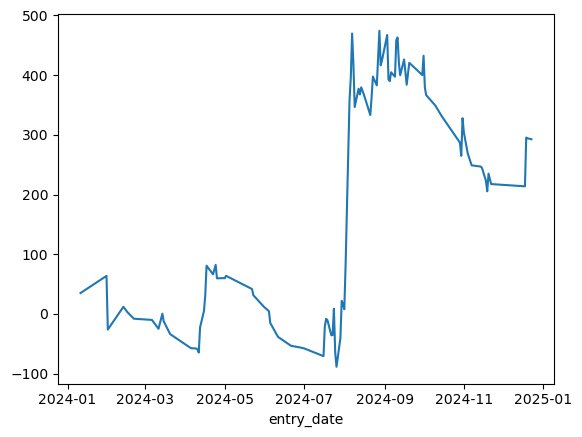

In [53]:
daily_profits.cumsum().plot()

In [ ]:
daily_profits.mean()

In [ ]:
import pandas as pd
from io import StringIO

def analyze_trading_day_summary(trade_log_df, total_business_days):
    """
    Analyzes a trade log and provides a full summary of trading day types
    including counts and percentages of the total business days in a period.

    Args:
        trade_log_df (pd.DataFrame): The DataFrame containing trade history.
        total_business_days (int): The total number of business days in the period.

    Returns:
        pd.DataFrame: A formatted summary table of the analysis.
    """
    # Ensure the entry_date is a datetime object
    df = trade_log_df.copy()
    df['entry_date'] = pd.to_datetime(df['entry_date'])
    
    # --- Part 1: Analyze the traded days ---
    daily_status_df = df.groupby(df['entry_date'].dt.date).agg(
        sides_traded=('Side', lambda x: set(x))
    )
    daily_status_df['Status'] = daily_status_df['sides_traded'].apply(
        lambda sides: 'Hedged' if 'BUY' in sides and 'SELL' in sides else 'Naked/Not Hedged'
    )
    status_counts = daily_status_df['Status'].value_counts()
    
    # --- Part 2: Calculate all categories ---
    hedged_days = status_counts.get('Hedged', 0)
    naked_days = status_counts.get('Naked/Not Hedged', 0)
    total_traded_days = hedged_days + naked_days
    non_traded_days = total_business_days - total_traded_days

    # --- Part 3: Create and format the final summary table ---
    summary_data = {
        'Category': ['Hedged Days', 'Naked Days (Not Hedged)', 'Total Days Traded', 'Non-Traded Days', 'Total Business Days (Approx.)'],
        'Count': [hedged_days, naked_days, total_traded_days, non_traded_days, total_business_days]
    }
    final_summary = pd.DataFrame(summary_data)
    
    # Calculate percentages
    final_summary['Percentage'] = (final_summary['Count'] / total_business_days * 100).map('{:.2f}%'.format)
    
    return final_summary


In [ ]:
analyze_trading_day_summary(local_trade_log2 , 252)

In [ ]:
local_trade_log2

In [ ]:
daily_profits = local_trade_log2.groupby(local_trade_log2['entry_date'].dt.date)['profit'].sum()

In [ ]:
daily_profits.cumsum().plot()

In [ ]:
if 'entry_date' in local_trade_log2.columns:

    local_trade_log2.set_index('entry_date' , inplace=True)

    local_trade_log2.sort_index( ascending=True, inplace=True)

if 'exit_date' in local_trade_log2.columns:
    local_trade_log2['exit_date'] = pd.to_datetime(local_trade_log2['exit_date'])

# Calculate the absolute percentage difference between entry and exit prices
local_trade_log2['price_change_pct'] = (local_trade_log2['exit_price'] - local_trade_log2['entry_price']).abs() / local_trade_log2['entry_price']

# Count trades before filtering
trades_before_filtering = len(local_trade_log2)

average_trade_profit = local_trade_log2['profit'].mean()

# First ensure consistent case for Side column
local_trade_log2['Side'] = local_trade_log2['Side'].str.lower()

# Calculate profit in bps (handles both buy/long and sell/short)
local_trade_log2['profit_bps'] = np.where(
    local_trade_log2['Side'].isin(['buy', 'long']),
    ((local_trade_log2['exit_price'] - local_trade_log2['entry_price']) / local_trade_log2['entry_price']) * 10000,
    ((local_trade_log2['entry_price'] - local_trade_log2['exit_price']) / local_trade_log2['entry_price']) * 10000)

# open_positions = list(long_position_count.values())
# print(f"Max open long positions are: {np.max(open_positions)}")

# open__short_positions = list(short_position_count.values())
# print(f"Max open shrt positions are: {np.max(open__short_positions)}")

total_trade_count = len(local_trade_log2)
max_entries_per_day = local_trade_log2.groupby(local_trade_log2.index.date).size().max()

# Identify losing trades and percentage

losers = local_trade_log2[local_trade_log2['profit'] < 0]
num_losing_trades = len(losers)
losers_percentage = (num_losing_trades / total_trade_count) * 100 if total_trade_count > 0 else 0

winners = local_trade_log2[local_trade_log2['profit'] > 0]

# 1. Create a pandas Series from your PnL data
pnl_series = pd.Series(total_pnl_series)

# 2. Find the minimum value in the series
max_unrealized_loss = pnl_series.min()

print(f"The highest unrealized loss (minimum PnL) was: ${max_unrealized_loss:,.2f}")

# Updated side checks throughout
num_long_trades = len(local_trade_log2[local_trade_log2['Side'].isin(['buy', 'long'])])
num_short_trades = len(local_trade_log2[local_trade_log2['Side'].isin(['sell', 'short'])])
print(f"Number of long trades: {num_long_trades} and short trades: {num_short_trades} out of total trades: {total_trade_count}")

# Updated profit calculations
avg_long_profit_bps = local_trade_log2[local_trade_log2['Side'].isin(['buy', 'long'])]['profit_bps'].mean()
avg_short_profit_bps = local_trade_log2[local_trade_log2['Side'].isin(['sell', 'short'])]['profit_bps'].mean()
print(f"Average long trade profit: {avg_long_profit_bps:.2f} bps and short: {avg_short_profit_bps:.2f} bps")

profit_total_long = local_trade_log2[local_trade_log2['Side'].isin(['buy', 'long'])]['profit'].sum()
profit_total_short = local_trade_log2[local_trade_log2['Side'].isin(['sell', 'short'])]['profit'].sum()
print(f"Net long profit: {profit_total_long:.2f} and short profit: {profit_total_short:.2f}")

# Compute holding period
local_trade_log2['holding_days'] = (local_trade_log2['exit_date'] - local_trade_log2.index).dt.days

# Compute equity curve (EC)
local_trade_log2['EC'] = (position_cap*100) + local_trade_log2['profit'].cumsum()

#============================================

# The index should be the 'exit_date' because that's when the equity changes
equity_at_exit = pd.Series(data=local_trade_log2['EC'].values, index=pd.to_datetime(local_trade_log2['exit_date']))

print(f"Equity at exit is : {equity_at_exit}")

# Print average trade profit
print(f"Average Trade Profit: {average_trade_profit:.2f}")

# Print profit in basis points (bps)
print("Profit (bps) for each trade:")
print(f"Avergae trade profit in bps : {local_trade_log2['profit_bps'].mean()}" )

# Print total trade count
print(f"Total Trade Count: {total_trade_count}")

# Print max entries per day
print(f"Max Entries Per Day: {max_entries_per_day}")

# Print number of losing trades
print(f"Number of Losing Trades: {num_losing_trades}")

print(f"Losing Trades Percentage: {losers_percentage:.2f}%")

# Print holding period
print("Avg Holding Period in (Days) :")
print(local_trade_log2['holding_days'].mean())

# Add: Number of trades with loss greater than 10% (i.e. -1000 bps)
loss_threshold_bps = -1000  # -10%
deep_losers = local_trade_log2[local_trade_log2['profit_bps'] < loss_threshold_bps]
num_deep_losers = len(deep_losers)

print(f"Number of Losing Trades > 10% Loss: {num_deep_losers}")

# Add: Average loss of all losing trades
avg_losing_trade = losers['profit'].mean()
print(f"Average Loss per Losing Trade: {avg_losing_trade:.4f}")

# Calculate average profit percentage (in % terms)
average_profit_percent = local_trade_log2['profit'].mean() / position_cap * 100
print(f"\nAverage Profit Percentage per Trade: {average_profit_percent:.2f}%")

# Calculate Trade Expectancy (in monetary terms)
win_rate = len(winners) / total_trade_count
avg_win = winners['profit'].mean()
avg_loss = losers['profit'].mean()
trade_expectancy = (win_rate * avg_win) - ((1 - win_rate) * abs(avg_loss))
print(f"Trade Expectancy: ${trade_expectancy:.2f} per trade")

# Calculate Risk-Adjusted Metrics
risk_reward_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else float('inf')
print(f"Risk-Reward Ratio: {risk_reward_ratio:.2f}:1")


# Add: Average loss of all losing trades
avg_winning_trade = winners['profit'].mean()
print(f"Average Loss per Losing Trade: {avg_winning_trade:.4f}")


abs_profit_df =  pd.DataFrame()
for symbol , data in absolute_symbol_pnl_series.items():

    tdf = pd.DataFrame(data , columns=['timestamp' , symbol])
    tdf.set_index('timestamp' , inplace=True)

    # Reindex to match df_index, filling missing values with 0
    abs_profit_df[symbol] = tdf.reindex(com_df2.index, fill_value=0)

max_unrealised_drawdown = abs_profit_df.sum(axis=1).min()
print(f"Max unrealised loss ( which is unrealised drawdown on notional) is {max_unrealised_drawdown}")


# Long/Short specific metrics
# Update all calculations to use the new condition
long_trades = local_trade_log2[local_trade_log2['Side'].isin(['buy', 'long'])]
short_trades = local_trade_log2[local_trade_log2['Side'].isin(['sell', 'short'])]

num_long_trades = len(long_trades)
num_short_trades = len(short_trades)

# Profit metrics
avg_long_profit_bps = long_trades['profit_bps'].mean()
avg_short_profit_bps = short_trades['profit_bps'].mean()
profit_total_long = long_trades['profit'].sum()
profit_total_short = short_trades['profit'].sum()

# Win/loss metrics
def calculate_consecutive_wins_losses(trades):
    trades = trades.sort_index()
    consecutive = []
    current_streak = 0
    prev_result = None

    for profit in trades['profit']:
        current_result = 'win' if profit > 0 else 'loss'
        if current_result == prev_result or prev_result is None:
            current_streak += 1
        else:
            consecutive.append((prev_result, current_streak))
            current_streak = 1
        prev_result = current_result

    if current_streak > 0:
        consecutive.append((prev_result, current_streak))

    return pd.DataFrame(consecutive, columns=['type', 'length'])

# Calculate for long and short separately
long_consecutive = calculate_consecutive_wins_losses(long_trades)
short_consecutive = calculate_consecutive_wins_losses(short_trades)

def print_streak_stats(name, df):
    if len(df) > 0:
        max_win_streak = df[df['type'] == 'win']['length'].max()
        max_loss_streak = df[df['type'] == 'loss']['length'].max()
        avg_win_streak = df[df['type'] == 'win']['length'].mean()
        avg_loss_streak = df[df['type'] == 'loss']['length'].mean()
        print(f"\n{name} Streaks:")
        print(f"Max Winning Streak: {max_win_streak}")
        print(f"Max Losing Streak: {max_loss_streak}")
        print(f"Avg Winning Streak: {avg_win_streak:.1f}")
        print(f"Avg Losing Streak: {avg_loss_streak:.1f}")

print_streak_stats("Long", long_consecutive)
print_streak_stats("Short", short_consecutive)

# Winning ratios
long_winners = len(long_trades[long_trades['profit'] > 0])
short_winners = len(short_trades[short_trades['profit'] > 0])

long_win_ratio = long_winners / num_long_trades if num_long_trades > 0 else 0
short_win_ratio = short_winners / num_short_trades if num_short_trades > 0 else 0

print(f"\nLong Trades Win Ratio: {long_win_ratio:.2%}")
print(f"\nShort Trades Win Ratio: {short_win_ratio:.2%}")

# Print all metrics
print("\n==========================================")
print(f"Number of long trades: {num_long_trades}")
print(f"Number of short trades: {num_short_trades}")
print(f"Total trades: {total_trade_count}")

print(f"\nAverage long trade profit: {avg_long_profit_bps:.2f} bps")
print(f"Average short trade profit: {avg_short_profit_bps:.2f} bps")
print(f"Net long profit: {profit_total_long:.2f}")
print(f"Net short profit: {profit_total_short:.2f}")

import matplotlib.pyplot as plt

# Scatter plot of trades
plt.figure(figsize=(12, 6))

# X-axis: trade index (or entry date if you want timeline)
x = range(len(local_trade_log2))

# Y-axis: profit
y = local_trade_log2['profit']

# Scatter: green for winners, red for losers
colors = ['green' if p > 0 else 'red' for p in y]

plt.scatter(x, y, c=colors, alpha=0.7, edgecolors='k')

# Add horizontal line at 0 (break-even)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("Scatter of Trade Profits")
plt.xlabel("Trade Index")
plt.ylabel("Profit ($)")
plt.show()



from IPython.display import HTML
import matplotlib.pyplot as plt
import base64
from io import BytesIO

# Create equity curve plot
plt.figure(figsize=(10, 6))
local_trade_log2['EC'].plot(title='Equity Curve', grid=True)
plt.ylabel('Portfolio Value')
plt.tight_layout()

# Save plot to temporary buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
plt.close()
plot_data = base64.b64encode(buffer.getvalue()).decode('utf-8')


#=== symbols specific

# 2. Group by the symbol name and calculate the sum of profits for each.
symbol_profits = local_trade_log2.groupby('name')['profit'].sum()

# Display the total profit for each symbol
print("--- Total Profit per Symbol ---")
print(symbol_profits)


# 3. Sort the results to easily find the best and worst.
sorted_symbols = symbol_profits.sort_values(ascending=False)


# 4. Extract the best and worst symbols from the sorted list.
# The best symbol is the first item (index 0).
best_symbol = sorted_symbols.index[0]
best_profit = sorted_symbols.iloc[0]

# The worst symbol is the last item (index -1).
worst_symbol = sorted_symbols.index[-1]
worst_loss = sorted_symbols.iloc[-1]


# 3. Sort the profits in ASCENDING order.
#    This places the symbols with the largest losses at the top.
sorted_by_loss = symbol_profits.sort_values(ascending=True)


# 4. Select the first 10 rows from the sorted list using .head(10).
worst_10_symbols = sorted_by_loss.head(10)


# 5. Print the final result.
print("--- 10 Worst Performing Symbols (by Total Profit) ---")
print(worst_10_symbols)

#======================================



# --- NEW: Calculate and print the additional statistics ---

# Count the number of symbols with negative total profit (losers)
num_loss_making_symbols = (symbol_profits <= 0).sum()

# Count the number of symbols with positive total profit (winners)
num_profit_making_symbols = (symbol_profits > 0).sum()

# Calculate the ratio of losers to winners
# Add a check to prevent division by zero if there are no winners
if num_profit_making_symbols > 0:
    loss_to_profit_ratio = num_loss_making_symbols / num_profit_making_symbols
else:
    loss_to_profit_ratio = float('inf') # Indicate infinite ratio if no winners

# Print the new stats
print("\n--- Symbol Profit/Loss Summary ---")
print(f"Number of Profit-Making Symbols: {num_profit_making_symbols}")
print(f"Number of Loss-Making Symbols:   {num_loss_making_symbols}")
print(f"Ratio of Loss-Makers to Profit-Makers: {loss_to_profit_ratio:.2f}")




def find_max_daily_gmv(trade_log):

    """
    Calculates the maximum and mean Gross Merchandise Value (GMV) on a single day
    from a trade log DataFrame. The mean calculation accounts for all days in the
    period, including non-trading days.

    Args:
        trade_log (pd.DataFrame): DataFrame containing the trade log. 
                                  Index must be a datetime object ('entry_date').
                                  Must contain 'entry_price', 'exit_price', 
                                  'qty', and 'exit_date' columns.

    Returns:
        tuple: A tuple containing the max_gmv_value and the mean_gmv_value.
    """

    # Calculate the total value of each entry and exit transaction
    trade_log['entry_value'] = trade_log['entry_price'] * trade_log['qty']
    trade_log['exit_value'] = trade_log['exit_price'] * trade_log['qty']

    # Group all entry values by their calendar day and sum them up
    daily_entries = trade_log.groupby(trade_log.index.date)['entry_value'].sum()

    # Group all exit values by their calendar day and sum them up
    # CORRECTED: Group exits by 'exit_date', not the index ('entry_date')
    daily_exits = trade_log.groupby(trade_log['exit_date'].dt.date)['exit_value'].sum()

    # Combine the daily entry and exit sums to get the total GMV for each day
    # This series only contains days where a trade occurred.
    daily_gmv = daily_entries.add(daily_exits, fill_value=0)

    # Find the maximum value. This can be done before reindexing for efficiency.
    if daily_gmv.empty:
        return 0, 0
    max_gmv_value = daily_gmv.max()

    # --- MODIFICATION TO ACCOUNT FOR NON-TRADING DAYS ---

    # 1. Determine the full date range of the backtest period.
    #    We use the earliest entry and latest exit to define the period.
    start_date = trade_log.index.min().date()
    end_date = trade_log['exit_date'].max().date()
    all_days_in_period = pd.date_range(start=start_date, end=end_date, freq='D')

    # 2. Reindex the 'daily_gmv' Series to include all days.
    #    This assigns a GMV of 0 to all non-trading days.
    daily_gmv = daily_gmv.reindex(all_days_in_period, fill_value=0)
    
    # --- END OF MODIFICATION ---

    # Now, this calculation correctly finds the mean over the entire period.
    mean_gmv_value = daily_gmv.mean()

    return max_gmv_value, mean_gmv_value


max_gmv , mean_gmv = find_max_daily_gmv(local_trade_log2)

print(f"Average daily GMV is {mean_gmv}")
print(f"Max daily gmv is {max_gmv}")


print(f"Return on average GMV is {local_trade_log2['profit'].sum()/mean_gmv}")
print(f"Return on average GMV is {local_trade_log2['profit'].sum()/max_gmv}")



# Create HTML report
html_report = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Backtest Performance Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        h1 {{ color: #2c3e50; border-bottom: 2px solid #3498db; }}
        h2 {{ color: #2980b9; }}
        .metric-container {{ display: flex; flex-wrap: wrap; gap: 20px; }}
        .metric-card {{
            background: #f8f9fa;
            border: 1px solid #dee2e6;
            border-radius: 5px;
            padding: 15px;
            flex: 1 1 300px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }}
        .metric-title {{ font-weight: bold; color: #2c3e50; }}
        .metric-value {{ font-size: 1.2em; color: #27ae60; }}
        .negative {{ color: #e74c3c; }}
        .plot-container {{ margin: 30px 0; text-align: center; }}
        table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
        th, td {{ padding: 10px; text-align: left; border-bottom: 1px solid #ddd; }}
        th {{ background-color: #3498db; color: white; }}
        tr:nth-child(even) {{ background-color: #f2f2f2; }}
    </style>
</head>
<body>
    <h1>Strategy Backtest Performance Report</h1>

    <div class="plot-container">
        <h2>Equity Curve</h2>
        <img src="data:image/png;base64,{plot_data}" alt="Equity Curve">
    </div>

    <h2>Key Performance Metrics</h2>
    <div class="metric-container">
        <div class="metric-card">
            <div class="metric-title">Total Trades</div>
            <div class="metric-value">{total_trade_count:,}</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Win Rate</div>
            <div class="metric-value">{100 - losers_percentage:.1f}%</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Average Trade Profit</div>
            <div class="metric-value">${average_trade_profit:,.2f}</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Trade Expectancy</div>
            <div class="metric-value">${trade_expectancy:,.2f}</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Risk-Reward Ratio</div>
            <div class="metric-value">{risk_reward_ratio:.2f}:1</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Max Drawdown</div>
            <div class="metric-value negative">${max_unrealised_drawdown:,.2f}</div>
        </div>
    </div>

    <h2>Long/Short Breakdown</h2>
    <table>
        <tr>
            <th>Metric</th>
            <th>Long Trades</th>
            <th>Short Trades</th>
        </tr>
        <tr>
            <td>Count</td>
            <td>{num_long_trades:,}</td>
            <td>{num_short_trades:,}</td>
        </tr>
        <tr>
            <td>Win Rate</td>
            <td>{long_win_ratio:.1%}</td>
            <td>{short_win_ratio:.1%}</td>
        </tr>
        <tr>
            <td>Avg Profit (bps)</td>
            <td>{avg_long_profit_bps:.1f}</td>
            <td>{avg_short_profit_bps:.1f}</td>
        </tr>
        <tr>
            <td>Total Profit</td>
            <td>${profit_total_long:,.2f}</td>
            <td>${profit_total_short:,.2f}</td>
        </tr>
        <tr>
            <td>Max Win Streak</td>
            <td>{long_consecutive[long_consecutive['type']=='win']['length'].max() if len(long_consecutive) > 0 else 0}</td>
            <td>{short_consecutive[short_consecutive['type']=='win']['length'].max() if len(short_consecutive) > 0 else 0}</td>
        </tr>
        <tr>
            <td>Max Loss Streak</td>
            <td>{long_consecutive[long_consecutive['type']=='loss']['length'].max() if len(long_consecutive) > 0 else 0}</td>
            <td>{short_consecutive[short_consecutive['type']=='loss']['length'].max() if len(short_consecutive) > 0 else 0}</td>
        </tr>
    </table>

    <h2>Position Sizing</h2>
    <div class="metric-container">
        
        <div class="metric-card">
            <div class="metric-title">Max Entries Per Day</div>
            <div class="metric-value">{max_entries_per_day}</div>
        </div>
    </div>

    <h2>Trade Duration</h2>
    <div class="metric-container">
        <div class="metric-card">
            <div class="metric-title">Avg Holding Days</div>
            <div class="metric-value">{local_trade_log2['holding_days'].mean():.1f}</div>
        </div>
    </div>
</body>
</html>
"""

# Display the report
HTML(html_report)

# To save the report to a file
with open('Nasdaq_Vol_stocks.html', 'w') as f:
    f.write(html_report)

local_trade_log2.to_csv("Nasdaq_TL.csv", index=True)

# Convert total_pnl_series dict (timestamp → pnl) into DataFrame
mtm_equity_df = pd.DataFrame(list(total_pnl_series.items()), columns=["timestamp", "MTM_PnL"])

# Sort by timestamp (important to keep the curve ordered)
mtm_equity_df.sort_values("timestamp", inplace=True)

# Add equity column: starting capital + cumulative PnL
mtm_equity_df["Equity"] = intial_capital + mtm_equity_df["MTM_PnL"].cumsum()

# Set timestamp as index for convenience
mtm_equity_df.set_index("timestamp", inplace=True)

# Define full path
mtm_equity_file = os.path.join(trades_strategy_folder, "MTM_equity.csv")

# Save to CSV
mtm_equity_df.to_csv(mtm_equity_file)

print(f"✅ MTM equity curve saved at: {mtm_equity_file}")


for symbol, data in absolute_symbol_pnl_series.items():
    if not data:
        print(f"No data for {symbol}, skipping.")
        continue
    try:
        tdf = pd.DataFrame(data, columns=['timestamp', 'pnl_absolute'])
        tdf.set_index('timestamp', inplace=True)
        file_path = os.path.join(df_folder, f"{symbol}_pnl.csv")
        tdf.to_csv(file_path)
        print(f"Successfully saved {file_path}")
    except Exception as e:
        print(f"Error processing {symbol}: {e}")


import quantstats as qs
qs.extend_pandas()

qs.reports.basic(local_trade_log2['EC'])

# --- 2. Plotting the 'EC' column ---
plt.figure(figsize=(12, 6)) # Optional: Adjust the figure size

local_trade_log2['EC'].plot(grid=True) # The main plotting command

# --- 3. Add labels and a title for clarity ---
plt.title('EC Over Time')
plt.xlabel('Date')
plt.ylabel('EC Value')

# --- 4. Display the plot ---
plt.show()


In [ ]:
# 2. Drop any duplicate rows, keeping the first occurrence
results_df = results_df.between_time('9:31' , '16:00')
results_df2 = results_df.rename(columns={'stockPrice': 'SPY_close'})
results_df2 = results_df2.drop_duplicates(keep='first')
results_df3 = results_df2[~results_df2.index.duplicated(keep='first')]

In [ ]:
def fetch_atm_option_at_timestamp(con, ticker: str, timestamp: pd.Timestamp, option_type: int):
    """
    Fetches specific data for the single, most At-The-Money (ATM) option contract 
    with DTE=1 at a specific timestamp.

    Args:
        con: The DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        timestamp (pd.Timestamp): The specific timestamp to query (assumed to be in UTC).
        option_type (int): The option type (1 for Calls, -1 for Puts).

    Returns:
        pd.DataFrame: A DataFrame with a single row containing the requested columns.
    """
    try:
        # Format the UTC timestamp for the query
        utc_timestamp_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
        date_str = timestamp.strftime('%Y-%m-%d')

        query = f"""
            WITH RankedOptions AS (
                SELECT ts, strike, expiry, close, bidPrice, dte, optionType ,
                    ROW_NUMBER() OVER(
                        ORDER BY ABS(strike - stockPrice) ASC
                    ) as atm_rank
                FROM read_parquet('s3://duckdata/ORATS/Options/ticker={ticker}/day={date_str}/*.parquet')
                WHERE 
                    ts = '{utc_timestamp_str}' AND
                    dte = 1 AND
                    optionType = {option_type}
            )
            -- VVV THIS LINE IS CHANGED VVV --
            SELECT 
                ts, strike, expiry, stockPrice, ticker
            FROM RankedOptions
            WHERE atm_rank = 1;
        """
        
        option_data = con.execute(query).df()
        return option_data

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [ ]:

# Create a sample UTC timestamp (US market open)
example_utc_ts = pd.Timestamp('2024-04-12 14:30:00')

# Call the function to find the most ATM DTE=1 Call at that exact minute
atm_call_data = fetch_atm_option_at_timestamp(
    con=con,
    ticker='SPY',
    timestamp=example_utc_ts,
    option_type=1  # 1 for Call
)

if not atm_call_data.empty:
    print("\n--- Found Most ATM DTE=1 Call ---")
    print(atm_call_data)

In [ ]:
# 2. Group by date and side to calculate profits
# .unstack() pivots the 'Side' into separate columns
daily_profits_by_side = local_trade_log2.groupby([local_trade_log2['entry_date'].dt.date, 'Side'])['profit'].sum().unstack(fill_value=0)

# 3. Calculate total and cumulative profits
daily_summary = daily_profits_by_side.sum(axis=1).rename('Total_Profit')
daily_summary = pd.concat([daily_profits_by_side, daily_summary], axis=1)
daily_summary['Cumulative_PnL'] = daily_summary['Total_Profit'].cumsum()

# Convert index to simple strings for plotting to avoid date formatting issues
daily_summary.index = pd.to_datetime(daily_summary.index).strftime('%Y-%m-%d')

print("## Daily Profit and Loss Summary")
print(daily_summary)

# 4. Plotting
plt.style.use('seaborn-v0_8-whitegrid')

# --- Plot 1: Daily & Cumulative PnL ---
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for daily total profit
colors = ['g' if x >= 0 else 'r' for x in daily_summary['Total_Profit']]
ax1.bar(daily_summary.index, daily_summary['Total_Profit'], color=colors, alpha=0.7, label='Daily PnL')
ax1.set_ylabel('Daily Profit/Loss ($)')
ax1.set_title('Daily and Cumulative Profit & Loss')
ax1.tick_params(axis='x', rotation=45)

# Line chart for cumulative PnL on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(daily_summary.index, daily_summary['Cumulative_PnL'], color='b', marker='o', linestyle='-', label='Cumulative PnL')
ax2.set_ylabel('Cumulative Profit/Loss ($)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('daily_and_cumulative_pnl.png')
plt.show()


# --- Plot 2: Daily PnL by Side ---
fig2, ax = plt.subplots(figsize=(10, 6))
daily_summary[['BUY', 'SELL']].plot(kind='bar', ax=ax, stacked=False, color=['#2ca02c', '#d62728'])
ax.set_title('Daily PnL by Trade Side (Buy vs. Sell)')
ax.set_ylabel('Profit/Loss ($)')
ax.set_xlabel('Date')
ax.tick_params(axis='x', rotation=0)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig('pnl_by_side.png')
plt.show()

In [ ]:
local_trade_log2

In [ ]:

# 2. Group by date and side to calculate profits
# .unstack() pivots the 'Side' into separate columns
daily_profits_by_side = local_trade_log2.groupby([local_trade_log2['entry_date'].dt.date, 'Side'])['profit'].sum().unstack(fill_value=0)
